# Lab 1 - Data exploration and preparation
10 April 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectBySingleFeaturePerformance, SelectByTargetMeanPerformance, ProbeFeatureSelection
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.impute import SimpleImputer
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Context

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.\
In this section, we'll focus on the analysis of the dataset and (some) pre-processing steps essential before creating the ML model.

We will use a subset of the dataset provided by the Mexican government - you can find it at this [link](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico).
Our dataset contains information about 10.000 pseudonymised patients (chosen ad hoc for educational purposes) who arrived at the Medical Unit with suspicious covid symptoms during the year 2023.

## Importing and reading Legend
Legend is an Excel file that contains:
- the variable name (as it appears in the dataset)
- a brief description of what it represents
- the type of the variable:
  - categorical (nominal, ordinal, boolean)
  - numerical (int, float)

In [3]:
legend = pd.read_excel('dictionary.xlsx')
legend

,Variables name,Variables description,type
0,record_id,Case identifier number.,string
1,gender,Identifies the patient's gender.,category
2,age,Identifies the patient's age.,int
3,nationality,Identifies if the patient is Mexican or foreign.,category
4,nationality_country,Identifies the patient's nationality.,category
5,admission_date,Identifies the date when the patient was admitted to the medical unit.,date
6,um_entity,Identifies the entity where the medical unit that provided the care is located.,category
7,patient_type,Identifies the type of care the patient received at the unit. It is called outpatient if they returned home or hospitalized if they were admitted to the hospital.,category
8,pregnancy,Identifies if the patient is pregnant.,boolean
9,diabetes,Identifies if the patient has a diabetes diagnosis.,boolean


In [4]:
# Let's create a dictionary with pairs of "variable name" and "type"
dtypes_dict = legend.set_index('Variables name')['type'].to_dict()
dtypes_dict = {key: value for key, value in dtypes_dict.items() if value != 'date'}
dtypes_dict

{'record_id': 'string',
 'gender': 'category',
 'age': 'int',
 'nationality': 'category',
 'nationality_country': 'category',
 'um_entity': 'category',
 'patient_type': 'category',
 'pregnancy': 'boolean',
 'diabetes': 'boolean',
 'copd': 'boolean',
 'asthma': 'boolean',
 'immunosuppression': 'boolean',
 'hypertension': 'boolean',
 'other_comorbidity': 'boolean',
 'cardiovascular': 'boolean',
 'obesity': 'boolean',
 'chronic_renal': 'boolean',
 'smoking': 'boolean',
 'pneumonia': 'boolean',
 'other_case': 'boolean',
 'intubated': 'boolean',
 'sat1': 'float',
 'sat2': 'float',
 'icu': 'boolean',
 'final_classification': 'category'}

In [5]:
# and we list variable names of date type
date_cols = list(legend[legend['type']=='date']['Variables name'])
date_cols

['admission_date', 'death_date']

## Import and read the dataset
Let's take a look at the first 20 rows of the dataset (how it is organized, the variables in it and so on).

In [6]:
df = pd.read_csv('dataset.csv', 
                 index_col = 0, # set id as index
                 parse_dates=date_cols,
                 date_format='%Y-%m-%d'
                )
df.head(20)

,gender,age,nationality,nationality_country,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g7e5075,F,12,Mexican,Mexico,2023-01-01,Morelos,Outpatient,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,non-COVID,NaT
g801a06,F,36,Mexican,Mexico,2023-01-01,Mexico City,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,99.764204,non-COVID,NaT
g434188,M,62,Mexican,Mexico,2023-01-01,Mexico,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.435332,NaN,non-COVID,2023-01-03
g407c28,M,58,Mexican,Mexico,2023-01-01,Puebla,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,99.222103,NaN,non-COVID,NaT
g3eeac3,F,32,Mexican,Mexico,2023-01-01,Tabasco,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,NaT
g35d721,F,42,Mexican,Mexico,2023-01-01,Nuevo León,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,COVID,NaT
g24531c,F,55,Mexican,Mexico,2023-01-01,Jalisco,Hospitalized,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,97.388867,97.388867,non-COVID,2023-01-12
g4500d5,F,78,Mexican,Mexico,2023-01-01,Mexico,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.995178,97.995178,non-COVID,2023-01-21
g2acaa7,M,60,Mexican,Mexico,2023-01-01,Baja California Sur,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,99.359554,99.359554,non-COVID,2023-01-25


An useful command to have an overview of the variables is:

In [7]:
df.info()
# not all variables are fully completed.. Also, Dtype does not correspond to the one we expected

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, g7e5075 to gc9a6d2
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   gender                10000 non-null  object        
 1   age                   10000 non-null  int64         
 2   nationality           10000 non-null  object        
 3   nationality_country   10000 non-null  object        
 4   admission_date        10000 non-null  datetime64[ns]
 5   um_entity             10000 non-null  object        
 6   patient_type          10000 non-null  object        
 7   pregnancy             5200 non-null   float64       
 8   diabetes              9982 non-null   float64       
 9   copd                  9985 non-null   float64       
 10  asthma                9986 non-null   float64       
 11  immunosuppression     9988 non-null   float64       
 12  hypertension          9986 non-null   float64       
 13  other_comorbi

Let's get into the dataset: with .head() we only have a partial vision of the possibile values.\
In general, understand which kind of values a variable admits, could be very useful to spot errors or simply to better undestand the data we are handling with.

In [8]:
colonne = df.columns.to_list()
# unique values of each column
for x in colonne:
    print(x,":", df[x].unique())

gender : ['F' 'M']
age : [ 12  36  62  58  32  42  55  78  60  31  93  51  26  28  82  83   1  63
  80  71  75  25  64  37  29  70  40  33  69  47  85  21  79   4   2   9
  27  72  57  76  81  56  87  73  54  24  86  45  23  88  53  67  66  92
  59  49  38  35  84  74  52  16  20  46  94  48  43  65  95  61  34  39
  41   3  22  14 107  77   7  50  97  30  91  89  44  68  90   6  18   8
  13  98  17  15  99 102  96  11  19   5  10 100   0 104 101]
nationality : ['Mexican' 'Foreign']
nationality_country : ['Mexico' 'Bolivia' 'United States of America' 'Venezuela' 'El Salvador'
 'Nicaragua' 'Brazil' 'Cuba' 'Guatemala' 'Other' 'Switzerland' 'Colombia'
 'Chile' 'Germany' 'Republic of Honduras' 'Canada']
admission_date : <DatetimeArray>
['2023-01-01 00:00:00', '2023-01-02 00:00:00', '2023-01-03 00:00:00',
 '2023-01-04 00:00:00', '2023-01-05 00:00:00', '2023-01-06 00:00:00',
 '2023-01-07 00:00:00', '2023-01-08 00:00:00', '2023-01-09 00:00:00',
 '2023-01-10 00:00:00',
 ...
 '2023-12-21 00:00:

In [9]:
#If the dataset contains two perfectly identical rows (probably inserted by mistake), this command deletes one of them.
df = df.drop_duplicates()

# Target/Class definition

What is the final aim of our machine learning model? Predict an event ("classification") or estimate a parameter ("regression")? 
Let's suppose in our case we are interested in predict wheather or not a new patient who arrives at the Medical Unit with supposed covid symptoms will die.\
Which kind of clinical sense this can have or how it could be used in clinical practice? For the moment, don't worry about that - this is just an example to look at the data.

What information do we have about death? death_date. We can think the column was filled out in this way:
- Date of death, if the patient is dead;
- Blank, if the patient is not dead.
This is a case where the blank values provide informations themselves and do not mean uncertainty.
NB: we are doing a strong assumption: before implement it, always check with who filled out the dataset.

So, let's create a boolean variable that says whether the patient is dead or not.

In [10]:
df['is_dead'] = ~df['death_date'].isna()
# How the target is distributed
df.is_dead.value_counts()

is_dead
False    6308
True     3692
Name: count, dtype: int64

Is this enough? Do we want predict dead in general? No - this would be a too easy task...! We may want to predict death in a certain time window starting from the date of admission.

In [11]:
#First, let's check if (for dead patients) death_date always is posterior to admission date.
df[(df['is_dead'] == True) & (df['admission_date'] > df['death_date'])] #OK

,gender,age,nationality,nationality_country,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [12]:
#Then, let's check if some patients do not have admission date registered.
print(f"Admission_date variable has {sum(df.admission_date.isna())} missing values.")

Admission_date variable has 0 missing values.


In [13]:
# Then, we can create a new column "tte" = Time to Event as difference (in days) between death date and admission date.
df["tte"] = df['death_date'] - df['admission_date']
df.tte.describe()

count                         3692
mean     7 days 06:40:57.204767063
std      8 days 15:19:26.064841359
min                0 days 00:00:00
25%                2 days 00:00:00
50%                4 days 00:00:00
75%               10 days 00:00:00
max              112 days 00:00:00
Name: tte, dtype: object

Let's create a new variable called "target" that answer to the question: Did the patient die within 10 days of arriving at the medical unit?

In [14]:
df["target"] = (df["tte"] < "10 days") & (df["is_dead"] == True)

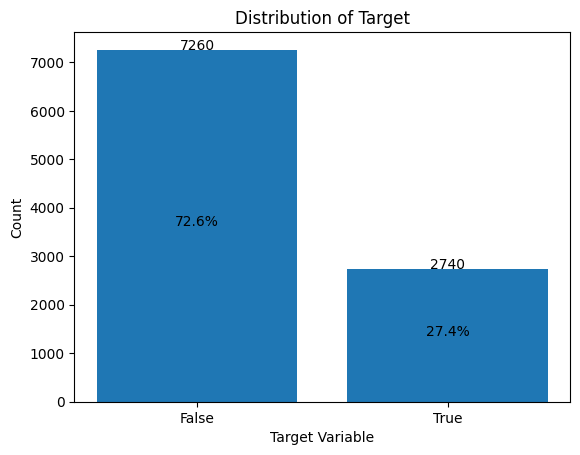

In [15]:
# Let's illustrate the distribution of the target variable

counts = df['target'].value_counts()
# Plot the counts using a bar plot
plt.bar(counts.index.astype(str), counts.values)

# Add labels and title
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Target')

total_count = counts.sum()
percentages = counts / total_count * 100

for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center')
    plt.text(i, count / 2, f'{percentages.iloc[i]:.1f}%', ha='center')

# Show plot
plt.show()

At this point, we can see the dataset is slightly _imbalanced_.

# Exploratory Data Analysis (EDA)

First of all, let's look at missing data:

In [16]:
print(df.isnull().sum())

gender                     0
age                        0
nationality                0
nationality_country        0
admission_date             0
um_entity                  0
patient_type               0
pregnancy               4800
diabetes                  18
copd                      15
asthma                    14
immunosuppression         12
hypertension              14
other_comorbidity         94
cardiovascular            13
obesity                    8
chronic_renal             13
smoking                   15
pneumonia                 32
other_case               321
intubated               5816
icu                     5816
sat1                    5410
sat2                    3993
final_classification       0
death_date              6308
is_dead                    0
tte                     6308
target                     0
dtype: int64


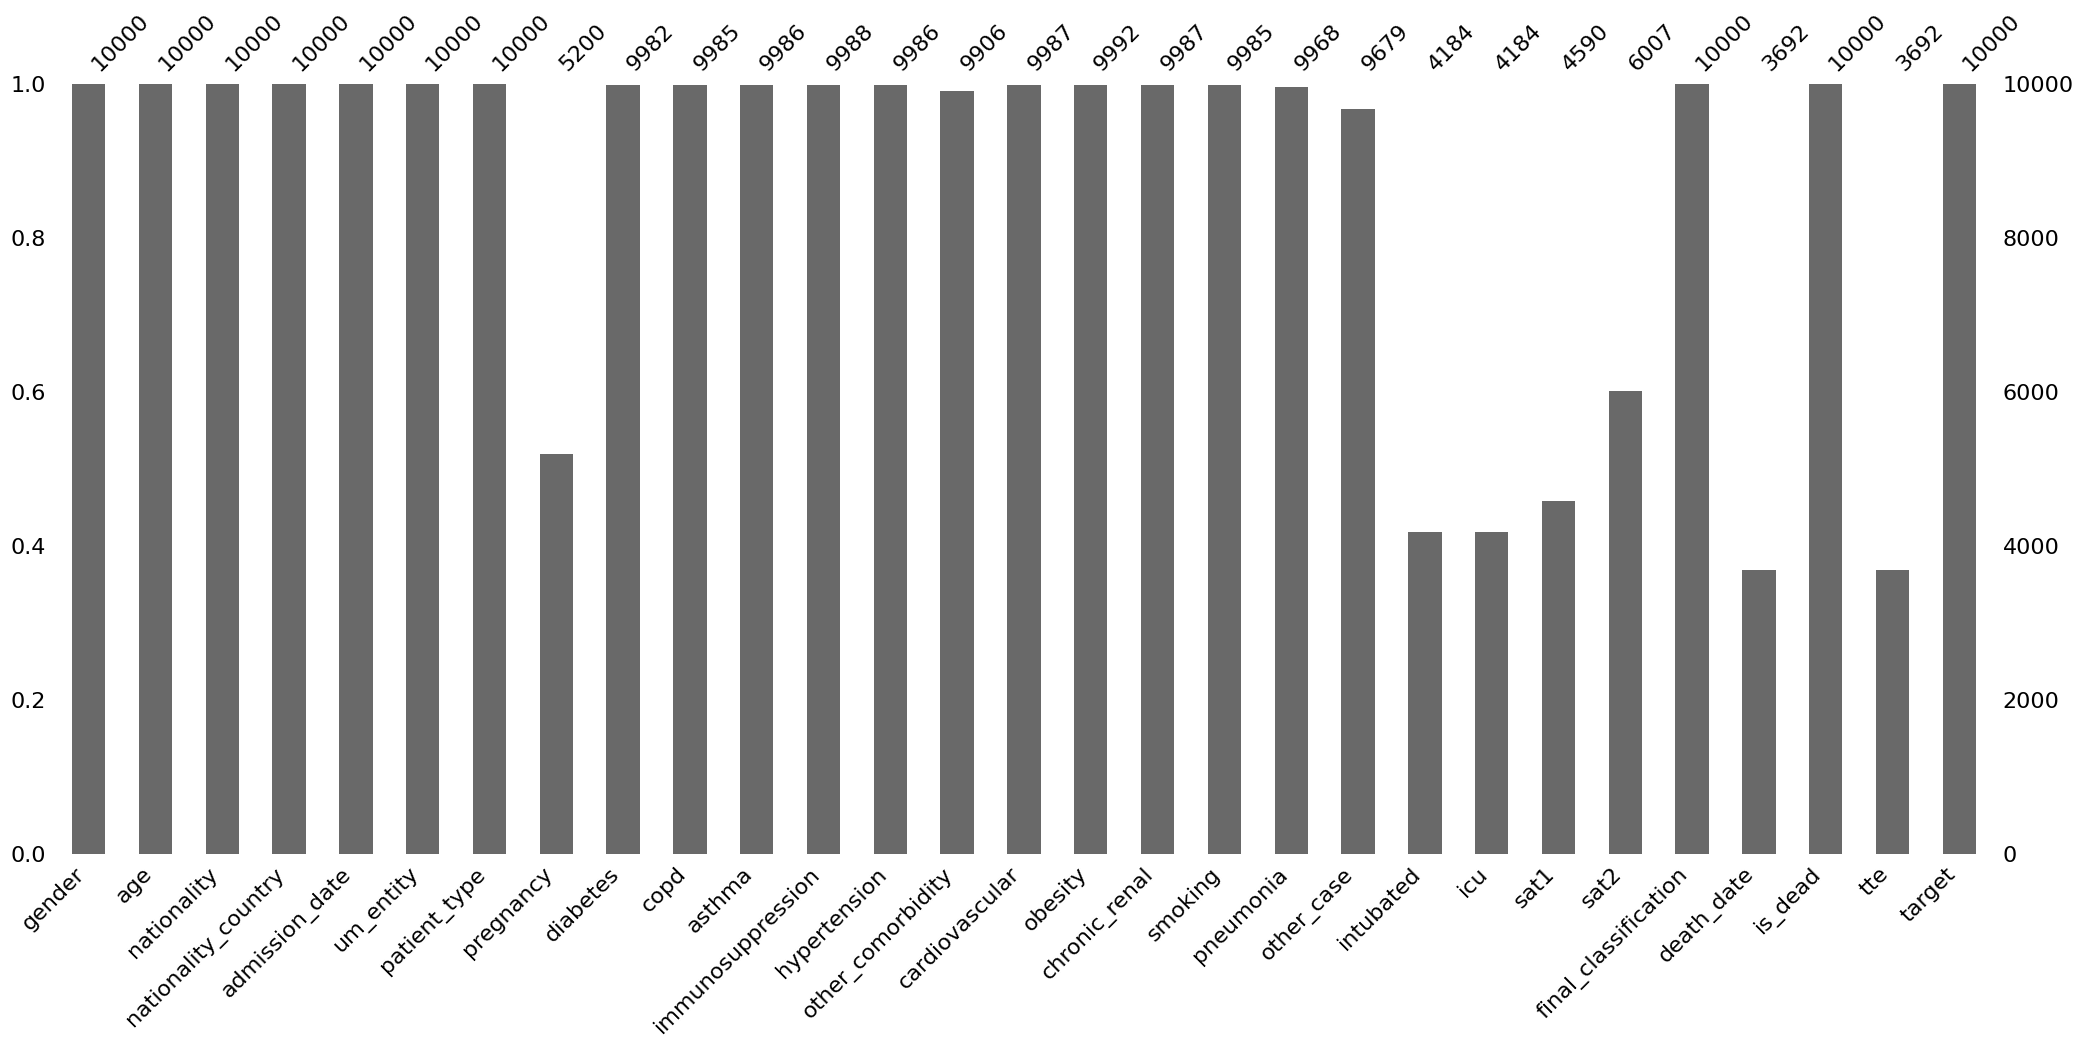

In [17]:
msno.bar(df)
plt.show()

Another viz in order to spot possible trends in data collection. This is intrinsically linked to the order of appearance of the patients in the dataset.

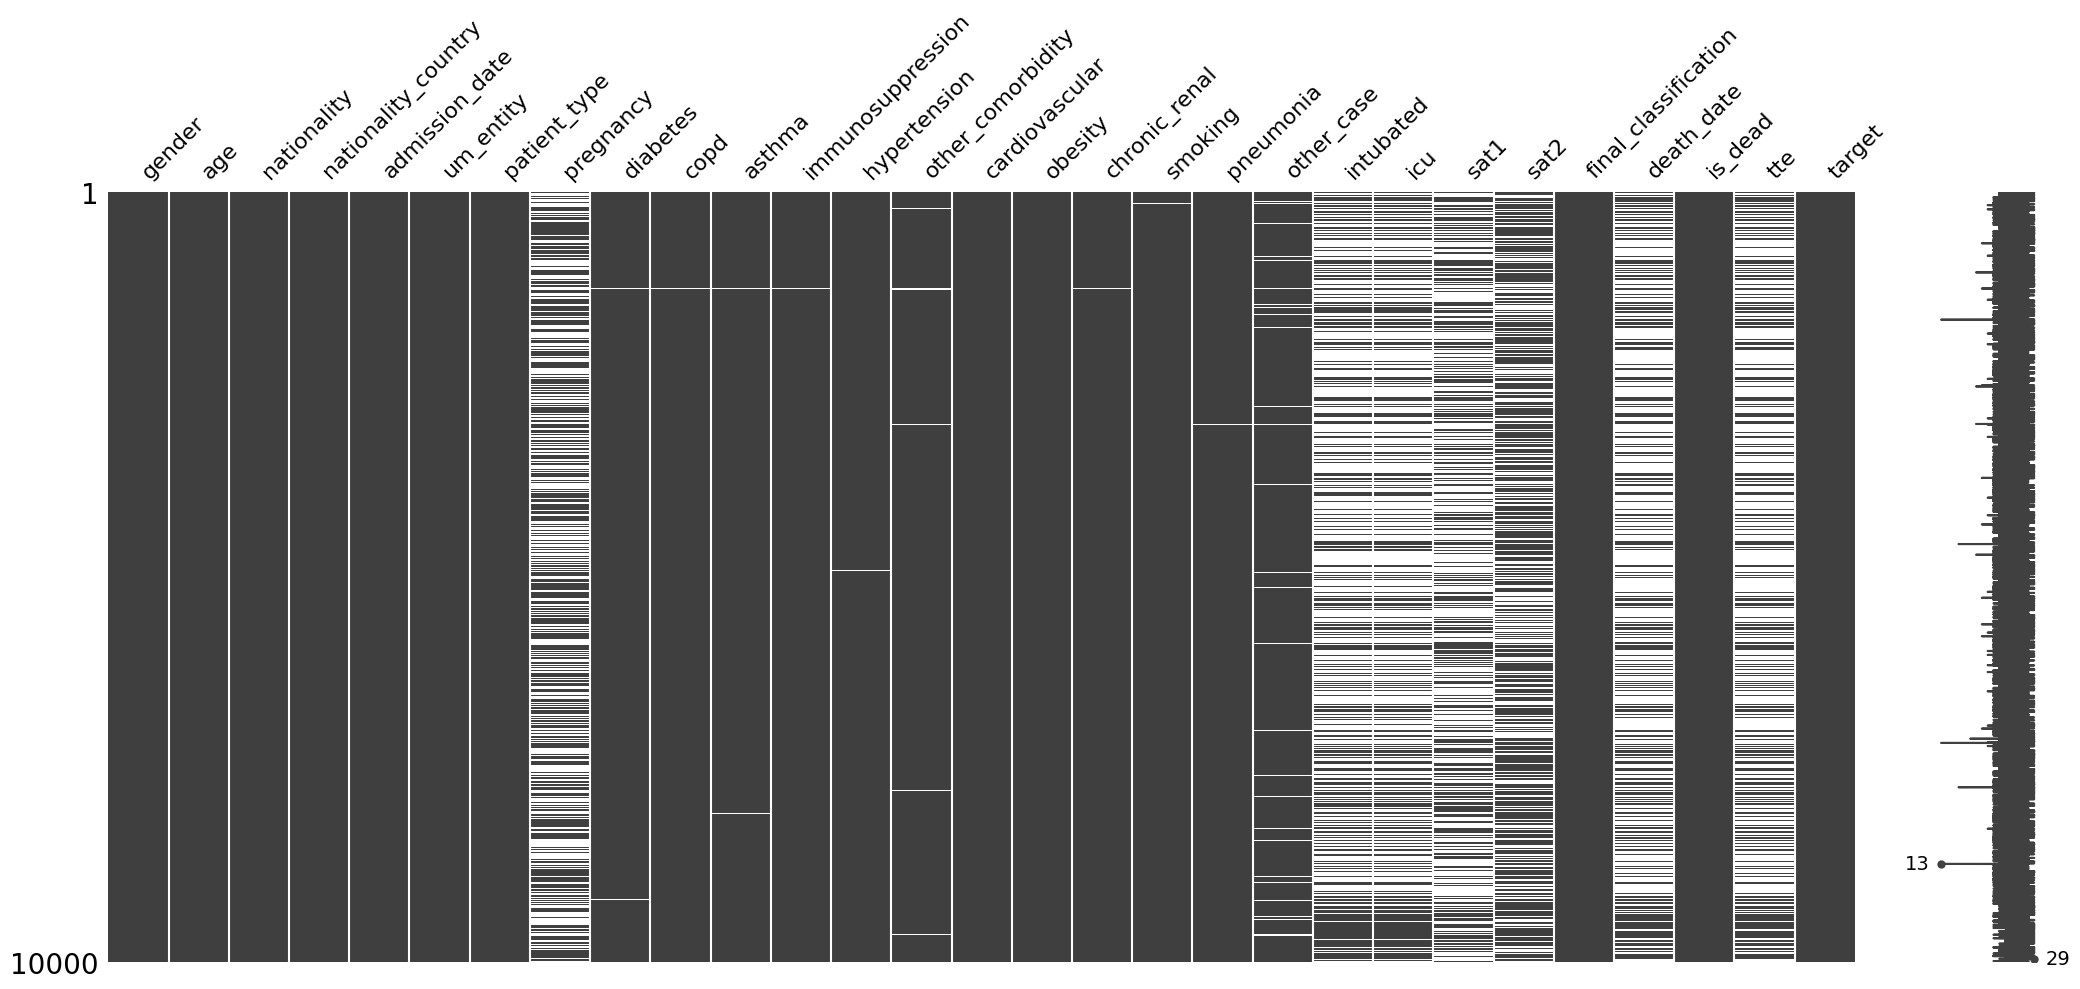

In [18]:
msno.matrix(df)
plt.show()

## Categorical Data

In [19]:
cat_variables = [key for key, value in dtypes_dict.items() if value == 'category']
cat_variables

['gender',
 'nationality',
 'nationality_country',
 'um_entity',
 'patient_type',
 'final_classification']

Visualize distribution and ....vs TARGET


GENDER variable has 2 distinct values ['F', 'M'] with distribution: 
        count
gender       
F        5232
M        4768


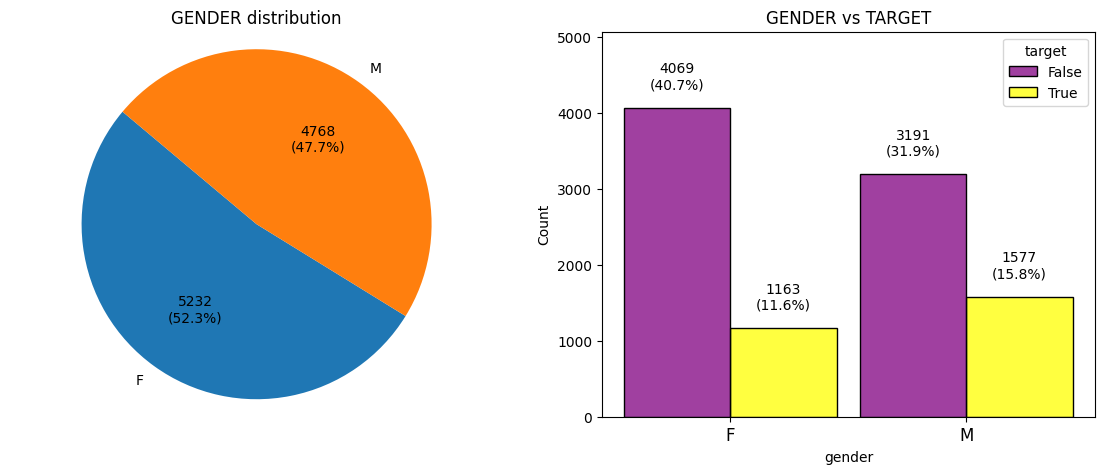


NATIONALITY variable has 2 distinct values ['Mexican', 'Foreign'] with distribution: 
             count
nationality       
Mexican       9968
Foreign         32


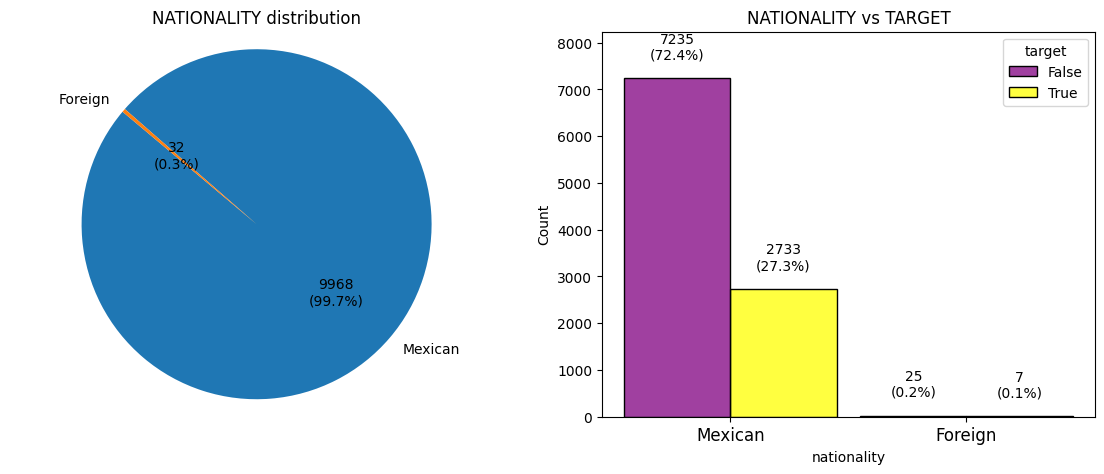


NATIONALITY_COUNTRY variable has 16 distinct values ['Mexico', 'Bolivia', 'United States of America', 'Venezuela', 'El Salvador', 'Nicaragua', 'Brazil', 'Cuba', 'Guatemala', 'Other', 'Switzerland', 'Colombia', 'Chile', 'Germany', 'Republic of Honduras', 'Canada'] with distribution: 
                          count
nationality_country            
Mexico                     9968
Republic of Honduras          6
Venezuela                     4
United States of America      3
Cuba                          3
Guatemala                     3
Nicaragua                     2
Colombia                      2
Chile                         2
Bolivia                       1
El Salvador                   1
Brazil                        1
Other                         1
Switzerland                   1
Germany                       1
Canada                        1

UM_ENTITY variable has 32 distinct values ['Morelos', 'Mexico City', 'Mexico', 'Puebla', 'Tabasco', 'Nuevo León', 'Jalisco', 'Baja Califor

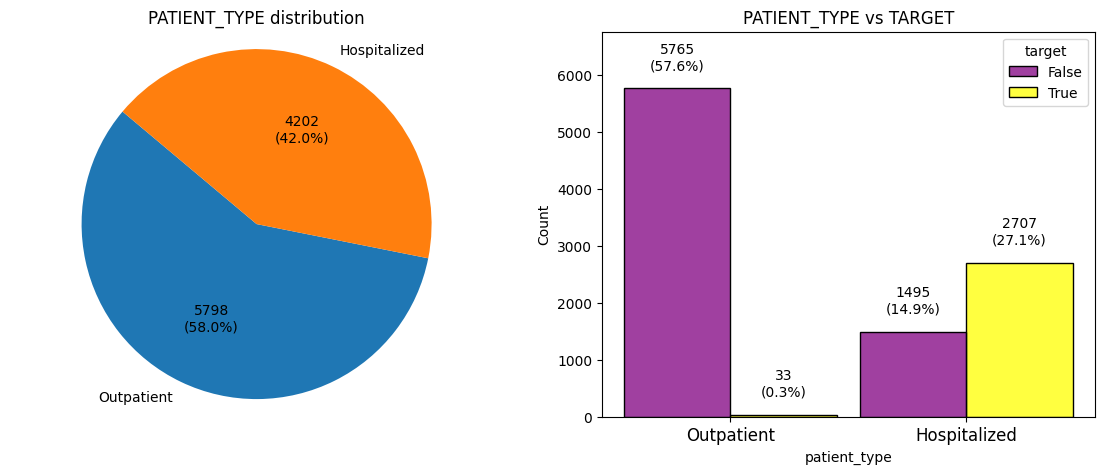


FINAL_CLASSIFICATION variable has 3 distinct values ['non-COVID', 'COVID', 'ND'] with distribution: 
                      count
final_classification       
non-COVID              6113
COVID                  3346
ND                      541


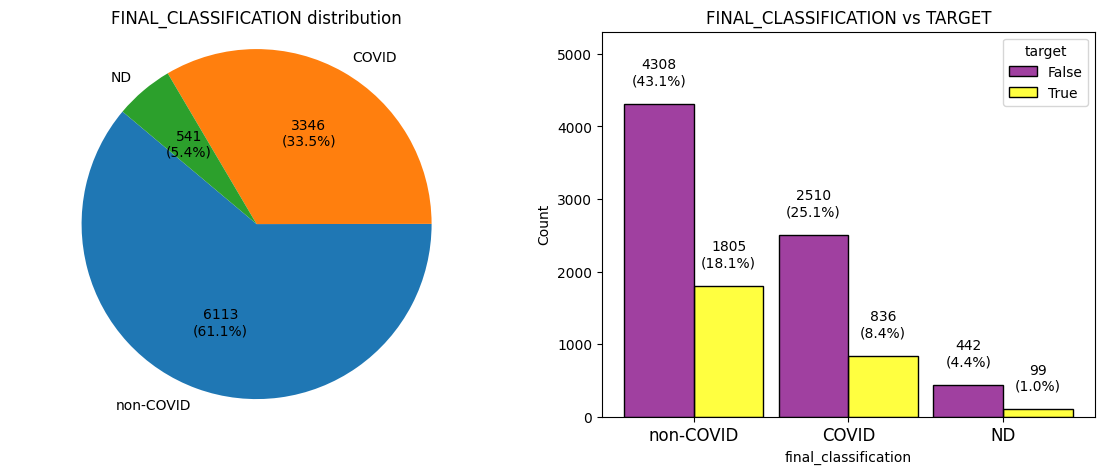

In [20]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n({val:1.1f}%)'
    
for x in cat_variables:
    category_counts = df[x].value_counts(dropna=False)
    print(f"\n{x.upper()} variable has {len(df[x].unique().tolist())} distinct values {df[x].unique().tolist()} with distribution: \n{pd.DataFrame(category_counts)}")
# Plotting
    if len(df[x].unique().tolist()) < 10:
        plt.figure(figsize=(14, 5)) 
        plt.subplot(1, 2, 1)
        
        plt.pie(category_counts, labels=category_counts.index, autopct=label_function #'%1.1f%%'
                ,startangle=140)
        plt.title(f'{x.upper()} distribution')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.subplot(1, 2, 2)
        ax=sns.histplot(data=df, x=x, hue='target', stat="count",  palette=['purple', 'yellow'], multiple="dodge", shrink=0.9, binwidth=0.3)
        plt.xticks(fontsize=12)
        array_get_height = []
        for p in ax.patches:
            color = p.get_facecolor()
            ax.annotate(f"{p.get_height():.0f}\n({p.get_height()/ len(df) * 100:.1f}%)\n", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom")
            array_get_height.append(p.get_height())
        ax.set_ylim([0, max(array_get_height) + 1000])
        plt.title(f'{x.upper()} vs TARGET')
        plt.show()

Variables like 'nationality' & 'nationality_country' seems quite useless for the model, since they are almost costant. Let's check this:

In [21]:
# Set up the transformer
from feature_engine.selection import DropConstantFeatures
transformer = DropConstantFeatures(tol=0.975, missing_values="ignore") 
# Fit the transformer
transformer.fit(df[cat_variables])
print(transformer.features_to_drop_)

['nationality', 'nationality_country']


In [22]:
# So, we can drop them
df.drop(transformer.features_to_drop_, axis=1, inplace=True, errors='ignore')
df

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
g7e5075,F,12,2023-01-01,Morelos,Outpatient,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,non-COVID,NaT,False,NaT,False
g801a06,F,36,2023-01-01,Mexico City,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,99.764204,non-COVID,NaT,False,NaT,False
g434188,M,62,2023-01-01,Mexico,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.435332,NaN,non-COVID,2023-01-03,True,2 days,True
g407c28,M,58,2023-01-01,Puebla,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,99.222103,NaN,non-COVID,NaT,False,NaT,False
g3eeac3,F,32,2023-01-01,Tabasco,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,NaT,False,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb8efdd,M,28,2023-12-28,Aguascalientes,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,96.502781,ND,NaT,False,NaT,False
gcaf097,F,55,2023-12-28,Guanajuato,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,97.521254,NaN,ND,NaT,False,NaT,False
gc085db,M,40,2023-12-28,Mexico,Hospitalized,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,ND,NaT,False,NaT,False


# Boolean Data

In [23]:
boolean_variables = [key for key, value in dtypes_dict.items() if value == 'boolean']
boolean_variables

['pregnancy',
 'diabetes',
 'copd',
 'asthma',
 'immunosuppression',
 'hypertension',
 'other_comorbidity',
 'cardiovascular',
 'obesity',
 'chronic_renal',
 'smoking',
 'pneumonia',
 'other_case',
 'intubated',
 'icu']

Visualize distribution and ....vs TARGET


PREGNANCY variable has 3 distinct values [0.0, nan, 1.0] with distribution:
           count
pregnancy       
0           5083
nan         4800
1            117


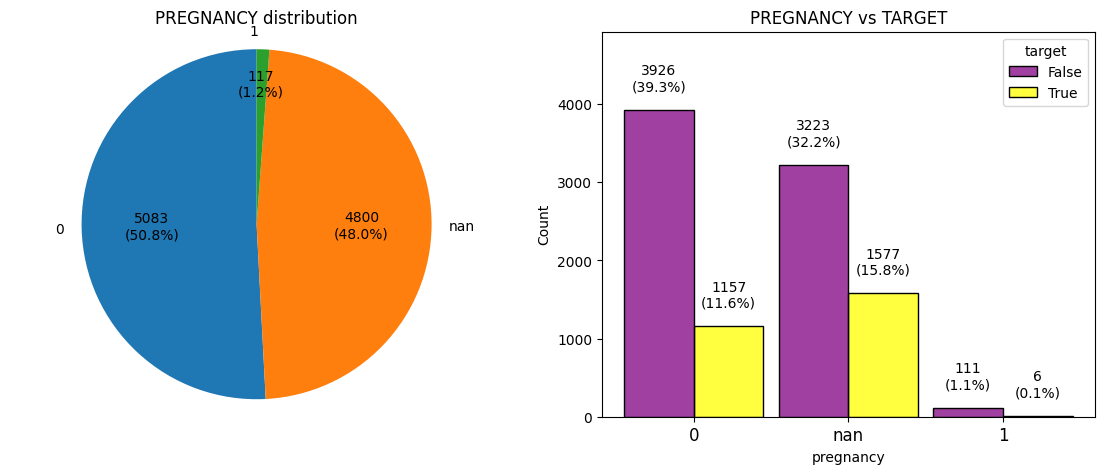


DIABETES variable has 3 distinct values [0.0, 1.0, nan] with distribution:
          count
diabetes       
0          8246
1          1736
nan          18


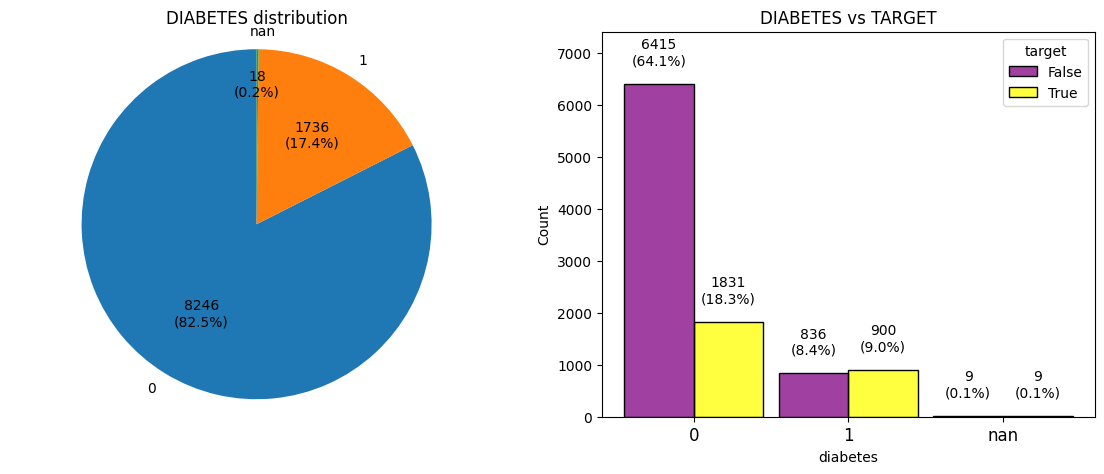


COPD variable has 3 distinct values [0.0, 1.0, nan] with distribution:
      count
copd       
0      9535
1       450
nan      15


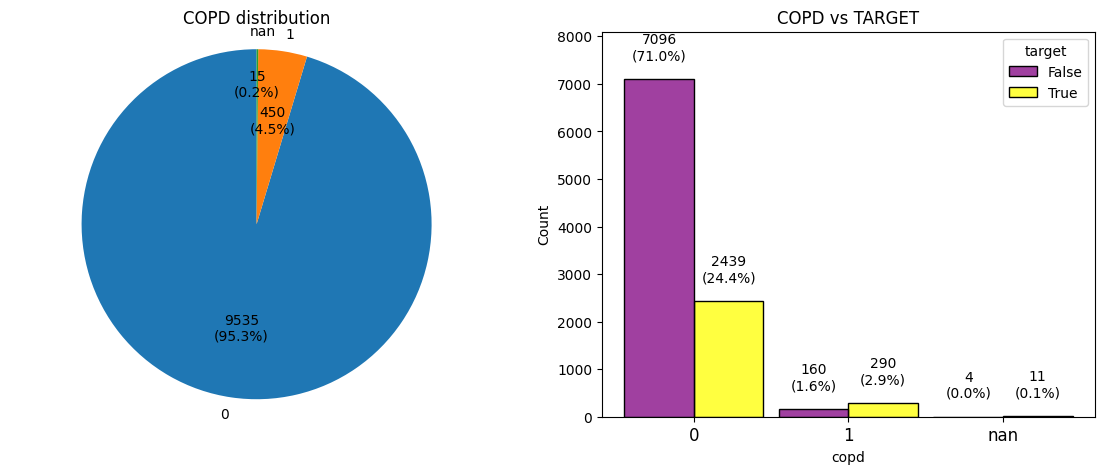


ASTHMA variable has 3 distinct values [1.0, 0.0, nan] with distribution:
        count
asthma       
0        9759
1         227
nan        14


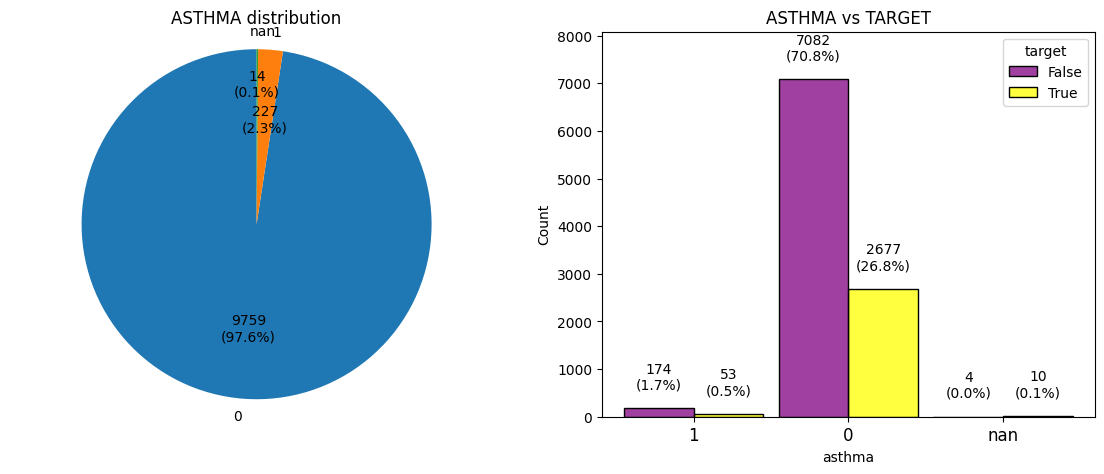


IMMUNOSUPPRESSION variable has 3 distinct values [0.0, 1.0, nan] with distribution:
                   count
immunosuppression       
0                   9677
1                    311
nan                   12


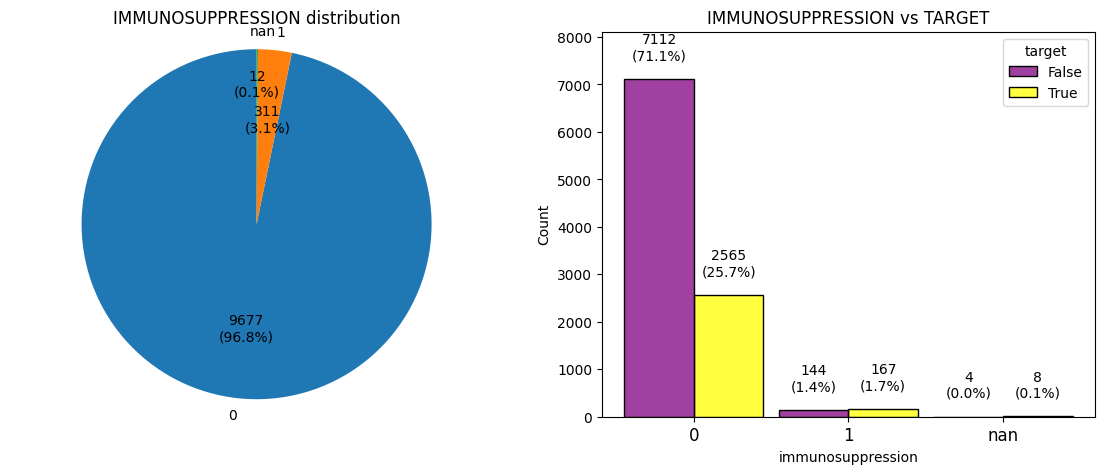


HYPERTENSION variable has 3 distinct values [0.0, 1.0, nan] with distribution:
              count
hypertension       
0              7893
1              2093
nan              14


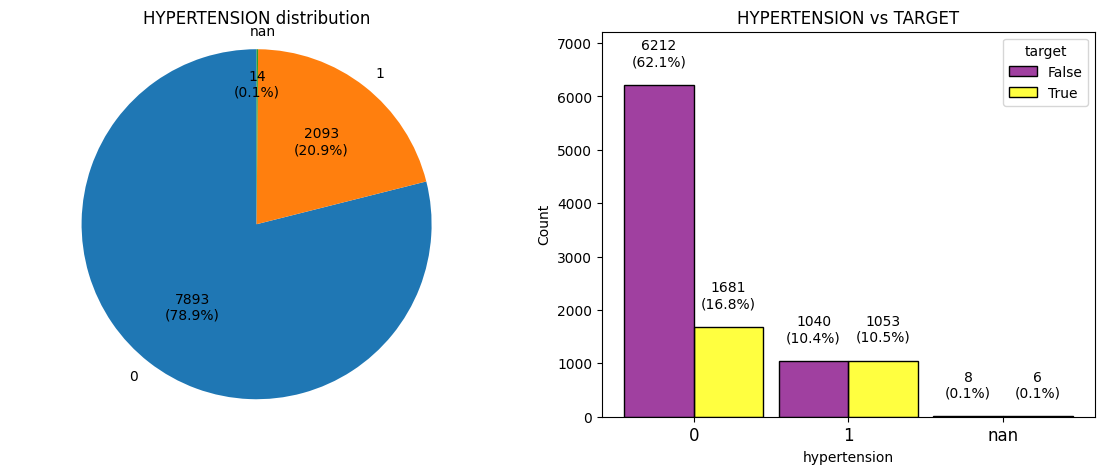


OTHER_COMORBIDITY variable has 3 distinct values [0.0, 1.0, nan] with distribution:
                   count
other_comorbidity       
0                   9507
1                    399
nan                   94


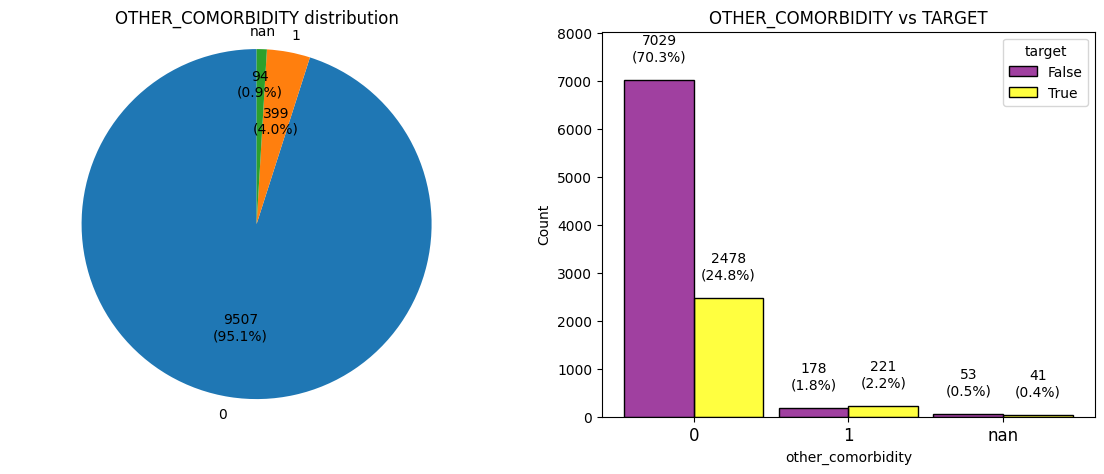


CARDIOVASCULAR variable has 3 distinct values [0.0, 1.0, nan] with distribution:
                count
cardiovascular       
0                9481
1                 506
nan                13


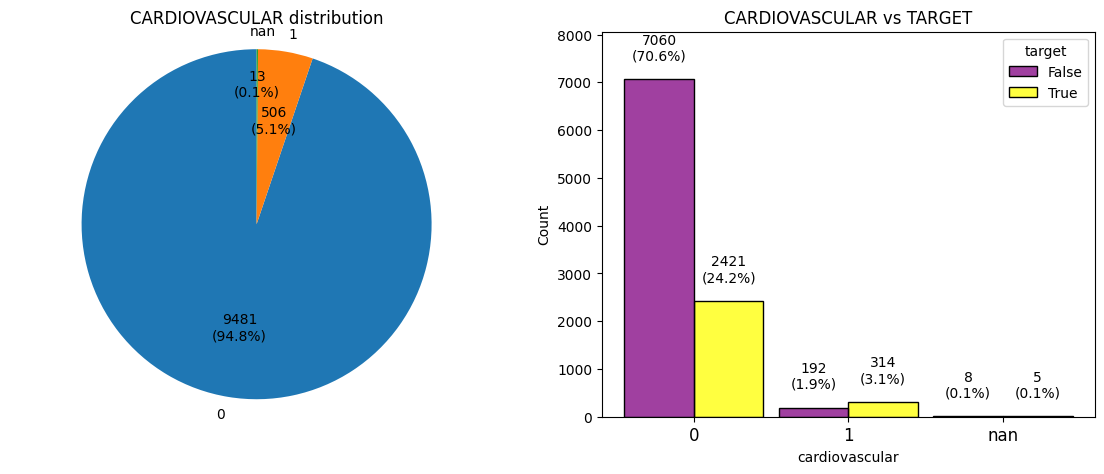


OBESITY variable has 3 distinct values [0.0, 1.0, nan] with distribution:
         count
obesity       
0         9128
1          864
nan          8


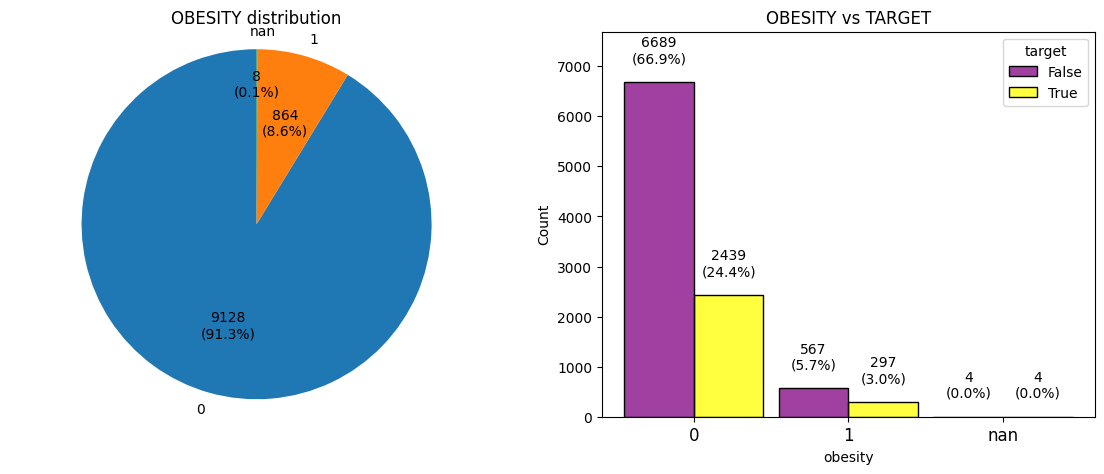


CHRONIC_RENAL variable has 3 distinct values [0.0, 1.0, nan] with distribution:
               count
chronic_renal       
0               9513
1                474
nan               13


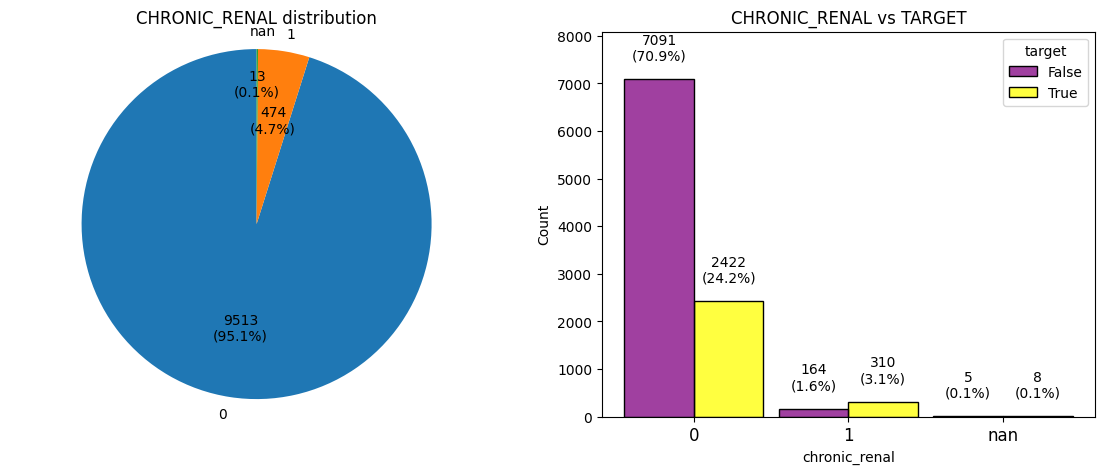


SMOKING variable has 3 distinct values [0.0, 1.0, nan] with distribution:
         count
smoking       
0         9371
1          614
nan         15


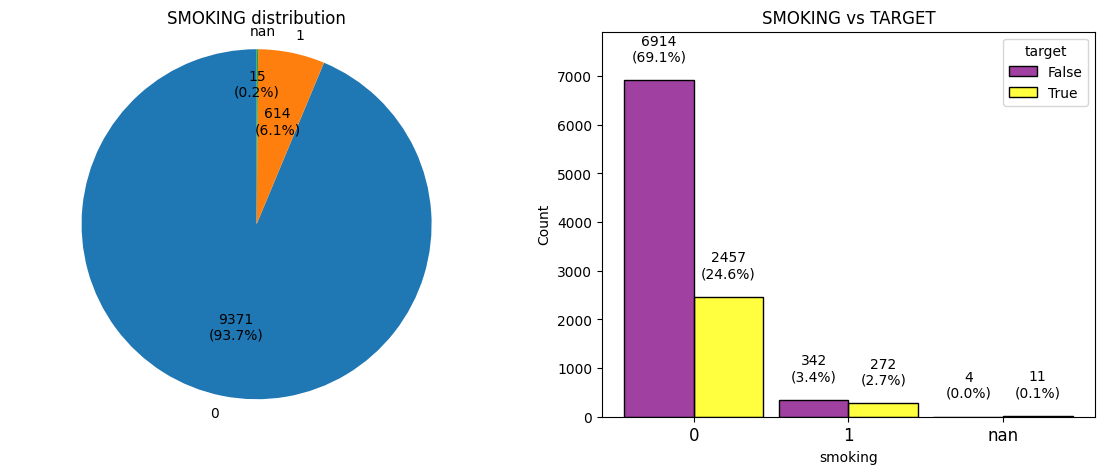


PNEUMONIA variable has 3 distinct values [0.0, 1.0, nan] with distribution:
           count
pneumonia       
0           7463
1           2505
nan           32


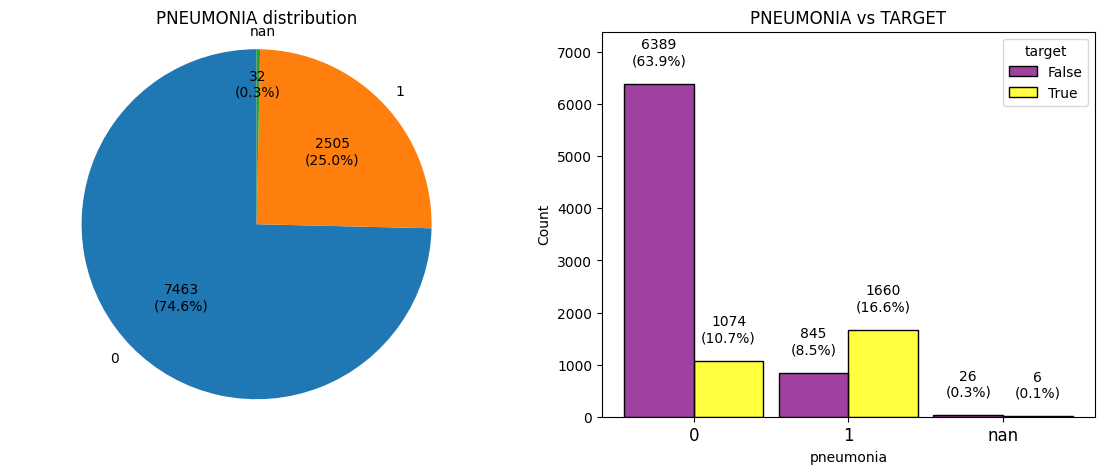


OTHER_CASE variable has 3 distinct values [0.0, 1.0, nan] with distribution:
            count
other_case       
0            8549
1            1130
nan           321


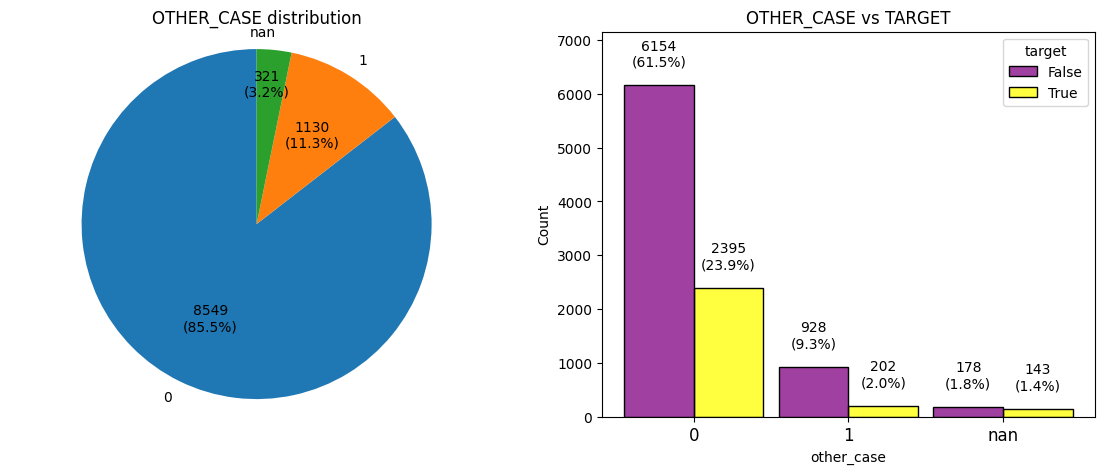


INTUBATED variable has 3 distinct values [nan, 0.0, 1.0] with distribution:
           count
intubated       
nan         5816
0           3461
1            723


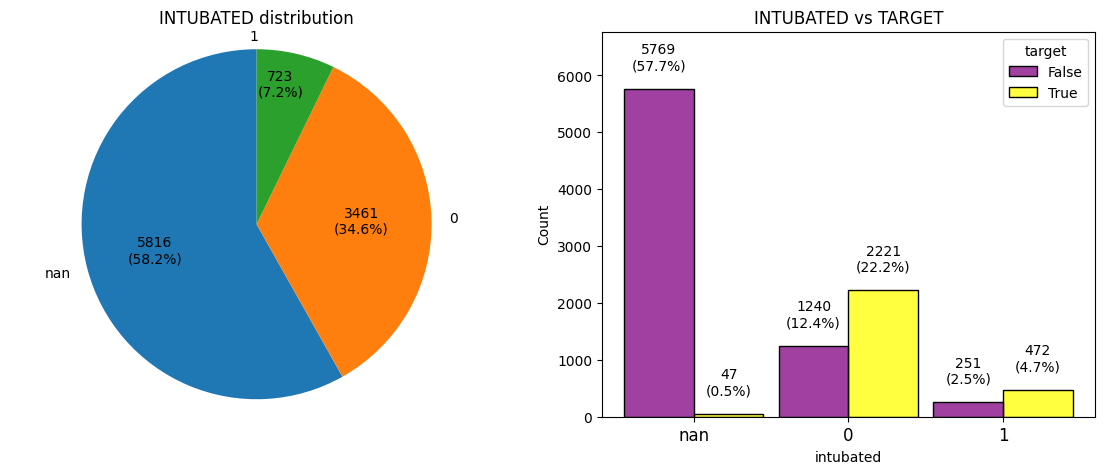


ICU variable has 3 distinct values [nan, 0.0, 1.0] with distribution:
     count
icu       
nan   5816
0     3845
1      339


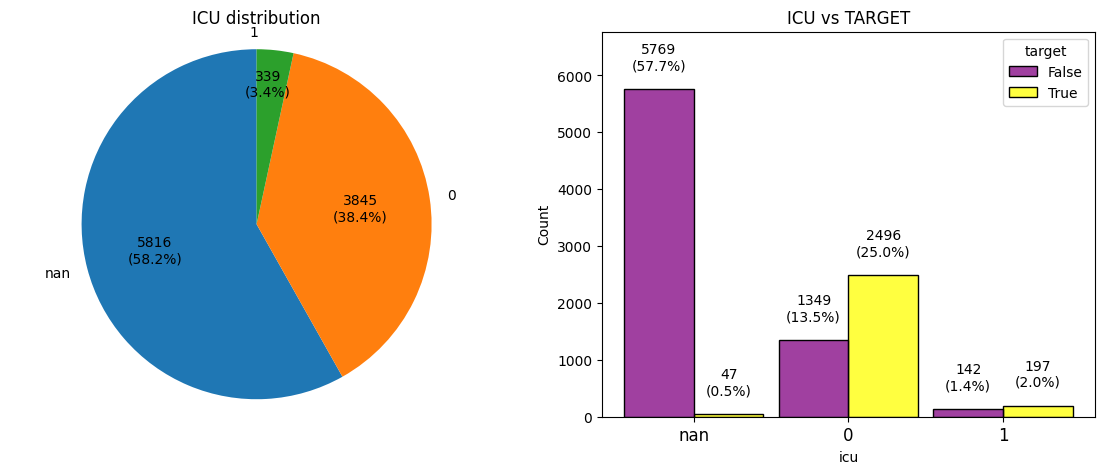

In [24]:
for x in boolean_variables:
    dg = df.copy()
    dg[x] = dg[x].replace([0,1,np.nan], ['0','1', 'nan'])
    bool_counts = dg[x].value_counts(dropna=False)
    print(f"\n{x.upper()} variable has {len(dg[x].unique().tolist())} distinct values {df[x].unique().tolist()} with distribution:\n{pd.DataFrame(bool_counts)}")
    array_get_height = []
# Plotting
    plt.figure(figsize=(14, 5)) 
    
    plt.subplot(1, 2, 1)
    patches, texts, autotexts = plt.pie(bool_counts, labels=bool_counts.index, autopct=label_function #'%1.1f%%'
    , startangle=90)
    autotexts[2]._y =+0.8 
    texts[2]._x =-0.04

    plt.title(f'{x.upper()} distribution')
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    ax=sns.histplot(data=dg, x=x, hue='target', stat="count",  palette=['purple', 'yellow'], multiple="dodge", shrink=0.9, binwidth=0.3)
    plt.xticks(fontsize=12)
    for p in ax.patches:
        color = p.get_facecolor()
        ax.annotate(f"{p.get_height():.0f}\n({p.get_height()/ len(df) * 100:.1f}%)\n", (p.get_x() + p.get_width() / 2, p.get_height()),
           ha="center", va="bottom")
        array_get_height.append(p.get_height())
    ax.set_ylim([0, max(array_get_height) + 1000])
    plt.xticks(fontsize=12)
    plt.title(f'{x.upper()} vs TARGET')
    plt.show()

'Immunosuppression', 'asthma', and other variables seems quite costant. Let's check this:

In [25]:
# Set up the transformer
from feature_engine.selection import DropConstantFeatures
transformer = DropConstantFeatures(tol=0.975, missing_values="ignore") 
# Fit the transformer
transformer.fit(df[boolean_variables])
print(transformer.features_to_drop_)

['asthma']


In [26]:
# If we set a treshold = 0.975, only 'asthma' -> So, we can drop it
df.drop(transformer.features_to_drop_, axis=1, inplace=True, errors='ignore')
boolean_variables.remove(transformer.features_to_drop_[0])
df

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g7e5075,F,12,2023-01-01,Morelos,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,non-COVID,NaT,False,NaT,False
g801a06,F,36,2023-01-01,Mexico City,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,99.764204,non-COVID,NaT,False,NaT,False
g434188,M,62,2023-01-01,Mexico,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.435332,NaN,non-COVID,2023-01-03,True,2 days,True
g407c28,M,58,2023-01-01,Puebla,Hospitalized,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,99.222103,NaN,non-COVID,NaT,False,NaT,False
g3eeac3,F,32,2023-01-01,Tabasco,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,NaT,False,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb8efdd,M,28,2023-12-28,Aguascalientes,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,96.502781,ND,NaT,False,NaT,False
gcaf097,F,55,2023-12-28,Guanajuato,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,97.521254,NaN,ND,NaT,False,NaT,False
gc085db,M,40,2023-12-28,Mexico,Hospitalized,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,ND,NaT,False,NaT,False


## Let's investigate some missing values

For example, 'pregnancy' has many missing. Can we spot why?

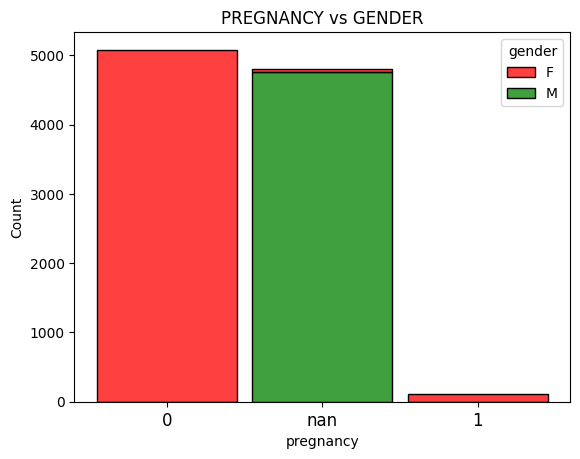

In [27]:
# Pregnancy vs gender
dg = df.copy()
dg['pregnancy'] = dg['pregnancy'].replace([0,1,np.nan], ['0','1', 'nan'])
sns.histplot(data=dg, x='pregnancy', hue='gender', stat="count", palette=['red', 'green'], multiple="stack", binwidth=0.3, shrink=0.9)
plt.xticks(fontsize=12)
plt.title(f'PREGNANCY vs GENDER')
plt.show()

It seems that all men have pregnancy null, in order to underline the fact that it's not that they are simply not pregnant, but that the attribute "be pregnant" is not applicable to men.
On the contrary, female can have pregnancy 0,1,nan. This NaN has a different meaning: probably it means the patient was not sure if she was pregnant.

In [28]:
df[(df['gender']=='F') & (df.pregnancy.isna())].head(5)

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g2cf92c,F,33,2023-01-02,Mexico City,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,95.492225,COVID,NaT,False,NaT,False
g35ec99,F,27,2023-01-03,Mexico City,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ND,NaT,False,NaT,False
g33abff,F,37,2023-01-04,Mexico City,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,non-COVID,NaT,False,NaT,False
g2cc81b,F,49,2023-01-04,Mexico City,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,92.166577,COVID,NaT,False,NaT,False
g3ed925,F,30,2023-01-05,Baja California Sur,Outpatient,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,COVID,NaT,False,NaT,False


In [29]:
#For male patients, let's set pregnancy = 0
df.loc[df.gender=="M", "pregnancy"] = 0

Let's now address 'intubated' and 'icu'. These attributes are registered only in case of hospitalization of the patient. So, let's investigate the relation with 'patient_type'

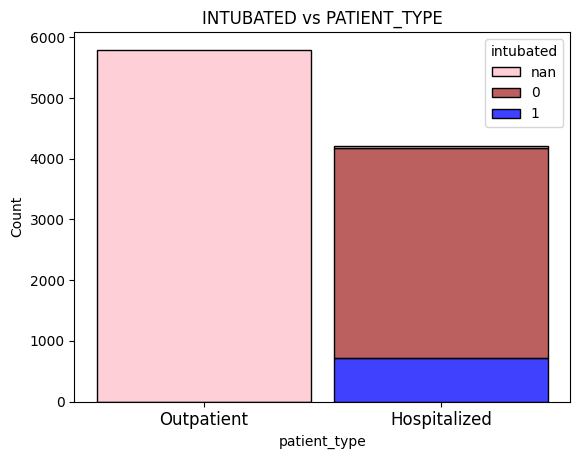

In [30]:
# intubated vs patient_type
dg['intubated'] = dg['intubated'].replace([0,1,np.nan], ['0','1', 'nan'])
sns.histplot(data=dg, x='patient_type', hue='intubated', stat="count", palette=['pink','brown','blue'], multiple="stack", binwidth=0.3,shrink=0.9)
plt.xticks(fontsize=12)
plt.title('INTUBATED vs PATIENT_TYPE')
plt.show()

All outpatients have intubated null, and this confirms our initial idea. There are some hospitalized patients with intubated = NaN. Here, with the help of clinicians we can do other hypotesis.

In [31]:
df[(df['patient_type']=='Hospitalized') & (df.intubated.isna())].head(5)

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g3b26fc,F,38,2023-01-03,Sonora,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,99.453551,non-COVID,NaT,False,NaT,False
g3264a5,M,87,2023-01-03,Mexico,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,98.013935,NaN,non-COVID,2023-01-14,True,11 days,False
g43a8a3,M,76,2023-01-06,Michoacán,Hospitalized,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,99.473951,99.473951,non-COVID,2023-01-09,True,3 days,True
g3fbf1f,M,68,2023-01-12,Veracruz,Hospitalized,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,94.426160,94.426160,ND,2023-01-24,True,12 days,False
g423826,M,63,2023-01-12,Coahuila de Zaragoza,Hospitalized,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,98.697947,98.697947,non-COVID,2023-01-17,True,5 days,True


The same for 'icu'

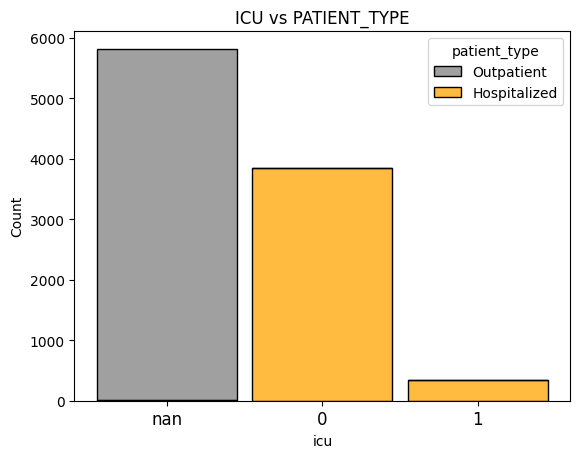

In [32]:
#icu vs patient_type
dg = df.copy()
dg['icu'] = dg['icu'].replace([0,1,np.nan], ['0','1', 'nan'])
sns.histplot(data=dg, x='icu', hue='patient_type', stat="count", palette=['grey', 'orange'], multiple="stack", binwidth=0.3, shrink=0.9)
plt.xticks(fontsize=12)
#for p in plt.gca().patches:
    #plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0,-10), textcoords='offset points')
plt.title('ICU vs PATIENT_TYPE')
plt.show()

Every outpatient has 'icu' = NaN, and this is resonable.

In [33]:
#For outpatients, let's set intubated/icu = 0
df.loc[df.patient_type=="Outpatient", "intubated"] = 0
df.loc[df.patient_type=="Outpatient", "icu"] = 0

# Numerical Data

In [34]:
num_variables = [key for key, value in dtypes_dict.items() if (value == 'float') or (value == 'int')]
num_variables

['age', 'sat1', 'sat2']

First of all, let's deal with 'Age'. It can be useful to plot distribution through histograms, so we can spot possible wrong or off-scale values. 


age variable has 0 missing values.
count    10000.000000
mean        46.858500
std         24.209682
min          0.000000
25%         29.000000
50%         46.000000
75%         66.000000
max        107.000000
Name: age, dtype: float64


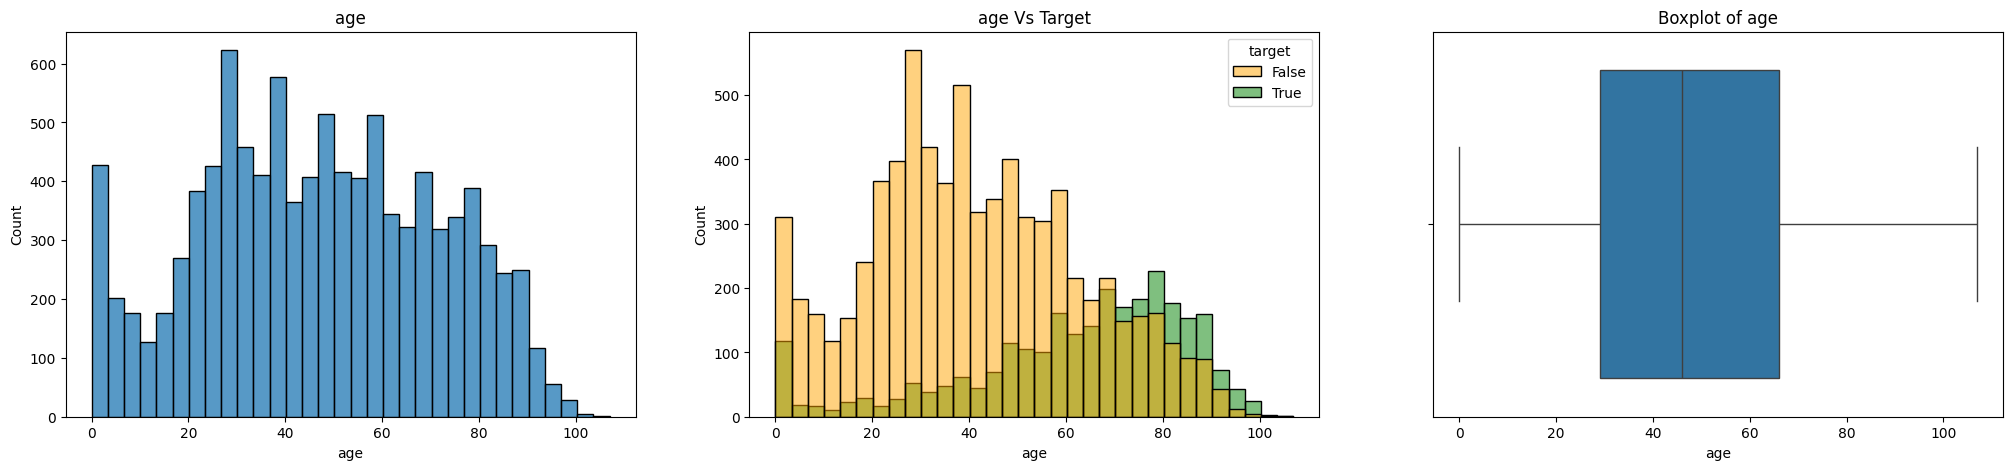

In [35]:
x = 'age'
print(f"\n{x} variable has {sum(df[x].isna())} missing values.")
print(df[x].describe())
# Plotting
plt.figure(figsize=(25, 5)) 

plt.subplot(1, 3, 1)
sns.histplot(data=df, x=x).set_title(f"{x}")

plt.subplot(1, 3, 2)
# come è distribuito il target rispetto al target?
sns.histplot(data=df, x=x, hue='target', palette=['orange', 'green']).set_title(f"{x} Vs Target")

plt.subplot(1,3,3)
sns.boxplot(x=df[x]).set_title(f"Boxplot of {x}")
plt.show()

From here we can see our patients' age varies from 0 to 107. No outliers are printed out (seaborn boxplot uses 1.5).\
Let's display patients less than one year old:

In [36]:
df[df.age==0]

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g22cefe,M,0,2023-02-08,San Luis Potosí,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,non-COVID,NaT,False,NaT,False
g3e7ba2,M,0,2023-02-17,Mexico City,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,NaT,False,NaT,False
g3c162d,M,0,2023-02-20,Sinaloa,Hospitalized,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,non-COVID,2023-02-28,True,8 days,True
g3bc5b1,F,0,2023-02-25,Guerrero,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,99.409472,non-COVID,2023-03-01,True,4 days,True
g2fbe05,M,0,2023-02-25,Sonora,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,99.397398,non-COVID,NaT,False,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g790842,F,0,2023-12-12,Oaxaca,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,NaT,False,NaT,False
g8e748a,M,0,2023-12-13,Michoacán,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,non-COVID,2023-12-13,True,0 days,True
ge758c1,F,0,2023-12-16,Aguascalientes,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,99.724117,non-COVID,NaT,False,NaT,False


Now let's focus on saturation measured by two different clinicians:


sat1 variable has 5410 missing values.
count    4590.000000
mean       95.140167
std         4.538516
min        85.005795
25%        91.442510
50%        97.475557
75%        98.719465
max        99.999728
Name: sat1, dtype: float64


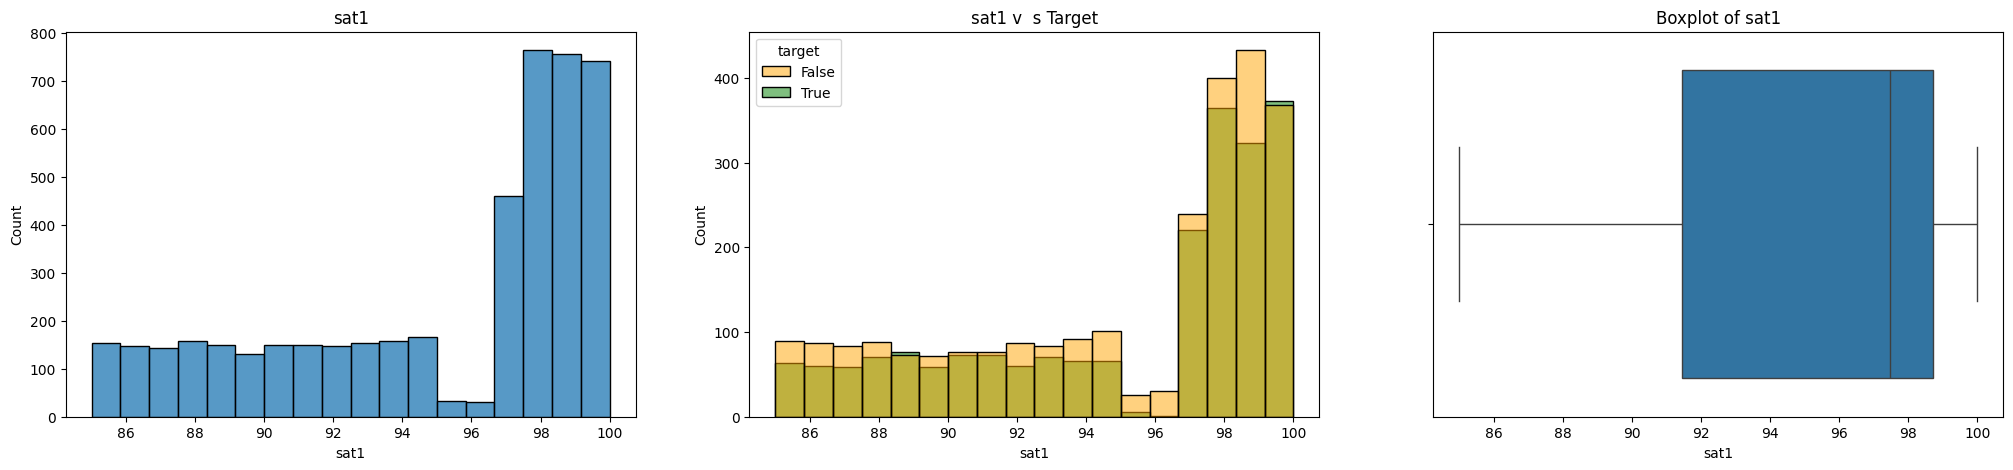


sat2 variable has 3993 missing values.
count    6007.000000
mean       96.388251
std         4.225471
min         9.223956
25%        94.600814
50%        98.063784
75%        99.352352
max        99.999840
Name: sat2, dtype: float64


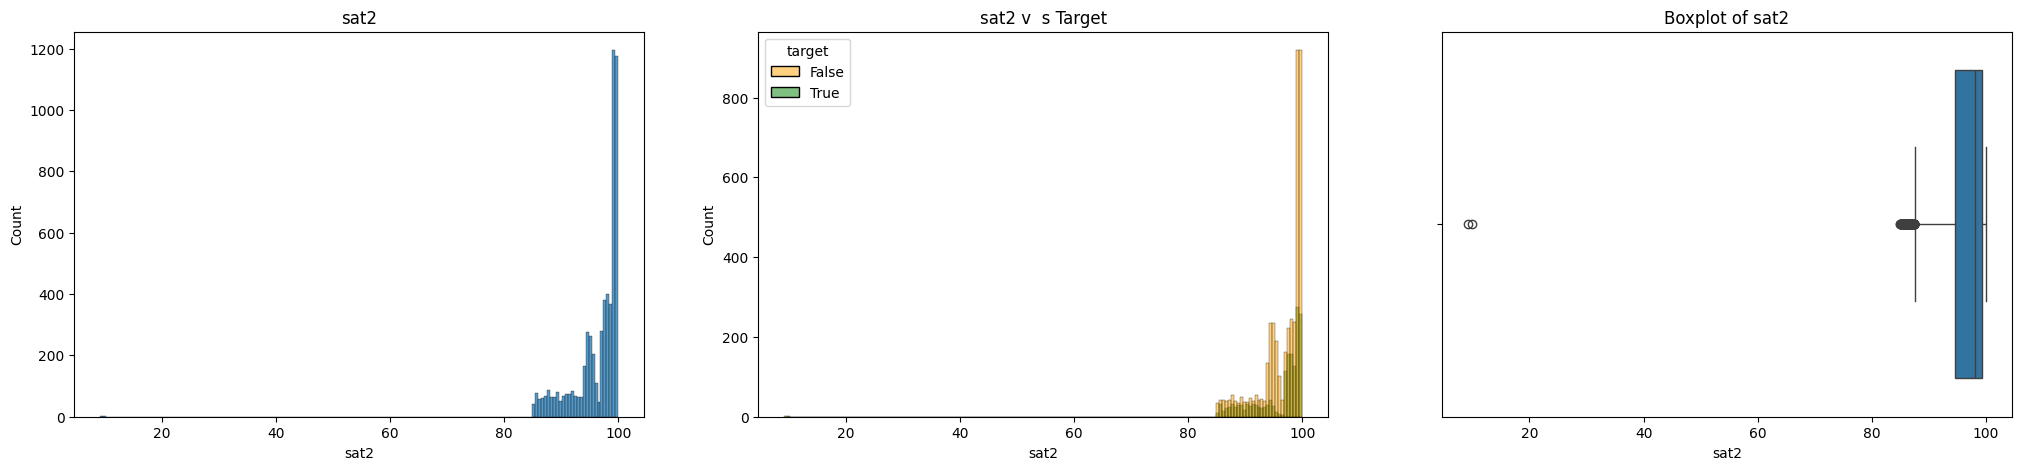

In [37]:
num_variables.remove('age')
for x in num_variables:
    print(f"\n{x} variable has {sum(df[x].isna())} missing values.")
    print(df[x].describe())
    # Plotting
    plt.figure(figsize=(25, 5)) 
    
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=x).set_title(f"{x}")
    
    plt.subplot(1, 3, 2)
    # come è distribuito il target rispetto al target?
    sns.histplot(data=df, x=x, hue='target', palette=['orange', 'green']).set_title(f"{x} v  s Target")
    
    plt.subplot(1,3,3)
    sns.boxplot(x=df[x]).set_title(f"Boxplot of {x}") # è ok
    plt.show()

sat1 values seem quite reasonable, while sat2 has some outliers (boxplot). How can we spot them?
- if we know the standard range of possible values for the attribute, we can look for values outside that range;
- otherwise, we can check which are the outliers with the interquartile method:
![Boxplot](boxplot.png)

In [38]:
df[df.sat2 < 20]

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g3da1bc,M,12,2023-01-11,Tabasco,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,9.973152,non-COVID,2023-01-15,True,4 days,True
ge6924a,M,45,2023-06-01,Chihuahua,Hospitalized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,9.223956,ND,2023-06-12,True,11 days,False


In [39]:
def iqr_outlier(x, factor):
    """
    Detect outliers with the IQR method: out of the range [Q1 - factor * IQR; Q3 + factor * IQR].

    Parameters:
    - x (pandas.core.series.Series): Column of the Dataset we want to detect outliers
    - factor: Usually, we use 1.5 or 3.

    Returns:
    pandas.core.series.Series: boolean column (True if the corrisponding value is an outlier, False otherwise).
    """
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = x.apply(lambda x : 1 if ((x < min_) | (x > max_)) else 0)
    return result_

In [40]:
df[iqr_outlier(df.sat2, 1.5) == 1]

,gender,age,admission_date,um_entity,patient_type,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat1,sat2,final_classification,death_date,is_dead,tte,target
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,
g34e67e,M,86,2023-01-02,Nuevo León,Hospitalized,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,86.353165,86.353165,COVID,2023-01-21,True,19 days,False
g235fc1,F,56,2023-01-03,Guanajuato,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.682666,86.682666,COVID,NaT,False,NaT,False
g2f6331,F,63,2023-01-03,Puebla,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.203742,86.203742,COVID,NaT,False,NaT,False
g25d287,F,60,2023-01-03,Mexico City,Hospitalized,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,86.541460,86.541460,COVID,2023-01-09,True,6 days,True
g4662c3,M,66,2023-01-03,Coahuila de Zaragoza,Hospitalized,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,85.446164,85.446164,COVID,2023-01-09,True,6 days,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g8586a4,M,45,2023-09-29,Mexico,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,85.423888,COVID,NaT,False,NaT,False
gdf27c2,F,42,2023-09-29,San Luis Potosí,Outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,86.958499,COVID,NaT,False,NaT,False
gac7ab1,F,83,2023-10-06,Jalisco,Hospitalized,0.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,85.691014,85.691014,COVID,2023-10-09,True,3 days,True


Once we spotted off-scale values, it's reasonable to think they were typos (comma). So, let's replace them with a more plausible value:

In [41]:
df.loc["g3da1bc", "sat2"] = df.loc["g3da1bc", "sat2"] * 10
df.loc["ge6924a", "sat2"] = df.loc["ge6924a", "sat2"] * 10

## Let's investigate some missing values

- Missing Completely at Random (MCAR): Missing data are randomly distributed across the variable and unrelated to other variables.
- Missing At Random (MAR): Missing data are not randomly distributed but they are accounted for by other observed variables.
- Missing Not At Random (MNAR): Missing data are not randomly distributed but are missing for reasons related to the values themselves.

sat 1 -> MAR

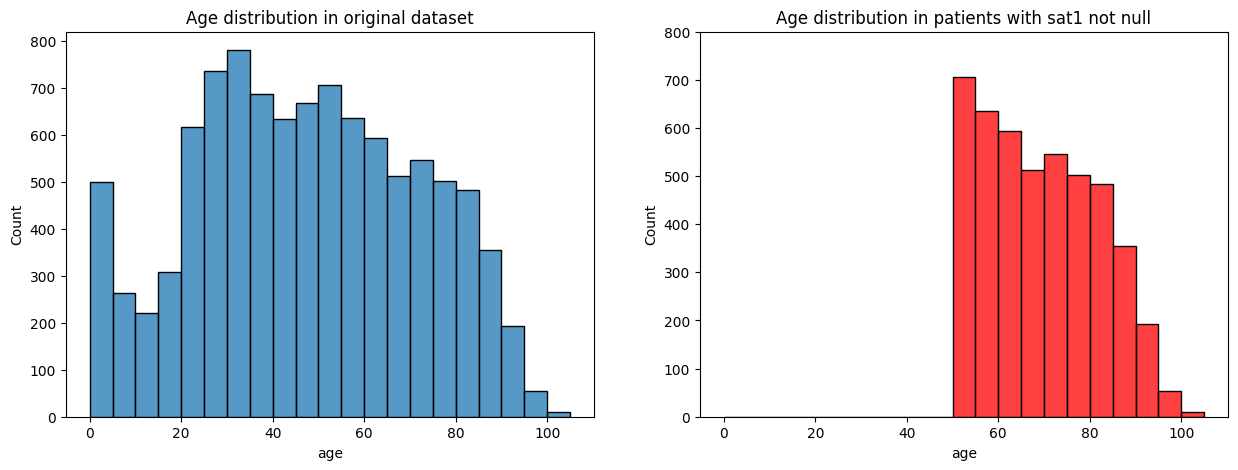

In [42]:
sat1_not_null= df[~df.sat1.isnull()]

plt.figure(figsize=(15, 5)) 

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='age', stat='count', bins=range(0,110,5)).set_title("Age distribution in original dataset")

plt.subplot(1, 2, 2)
ax = sns.histplot(data=sat1_not_null, x='age',stat='count', bins=range(0,110,5), color = "red")
ax.set_title("Age distribution in patients with sat1 not null")
ax.set_ylim([0, 800])

plt.show()

Let's check:

In [43]:
# patient with age < 50 == missing values in sat1?
(df['age'] < 50).sum() == (df['sat1'].isna()).sum()

True

sat 2 -> MCAR

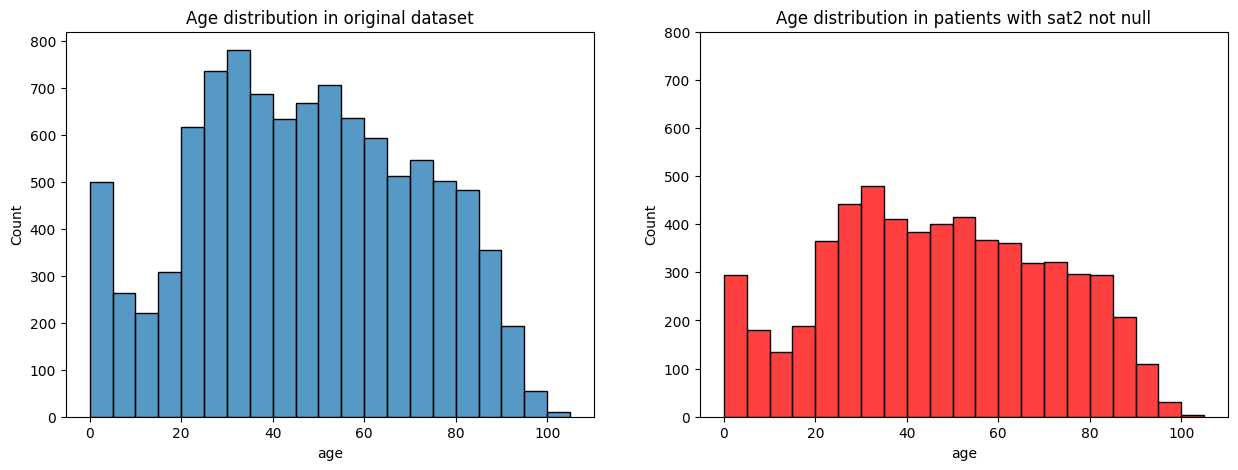

In [44]:
sat2_not_null=df[~df.sat2.isna()]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='age', stat='count', bins=range(0, 110, 5)).set_title("Age distribution in original dataset")

plt.subplot(1, 2, 2)
ax = sns.histplot(data=sat2_not_null, x='age', stat='count', bins=range(0,110,5), color = "red")
ax.set_title("Age distribution in patients with sat2 not null")
ax.set_ylim([0, 800])

plt.show()

In [45]:
# where the values are both present, are they equal?

In [46]:
p = pd.merge(sat1_not_null[['sat1']], sat2_not_null[['sat2']], on = "record_id", how = "inner") #2727 record

(p.sat1==p.sat2).sum() #yes

2727

We can create a new variable "sat" whit less missing by merging the two starting variables (which can be deleted).

In [47]:
df['sat'] = df['sat1'].combine_first(df['sat2'])

print(f"\nsat variable has {sum(df['sat'].isna())} missing values.")


sat variable has 2130 missing values.


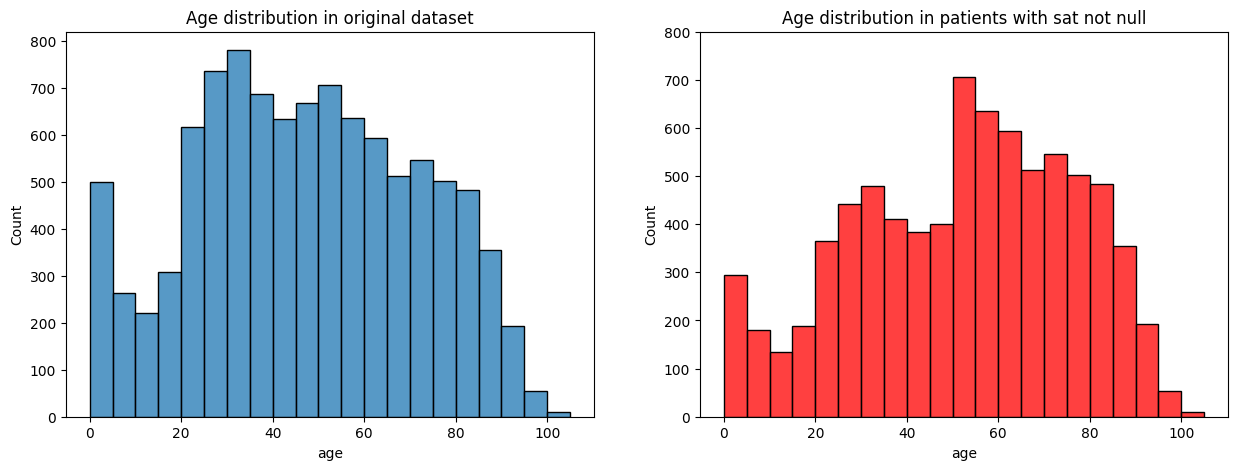

In [48]:
sat_not_null=df[~df.sat.isna()]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='age', stat='count', bins=range(0, 110, 5)).set_title("Age distribution in original dataset")

plt.subplot(1, 2, 2)
ax = sns.histplot(data=sat_not_null, x='age', stat='count', bins=range(0,110,5), color = "red")
ax.set_title("Age distribution in patients with sat not null")
ax.set_ylim([0, 800])

plt.show()

In [49]:
df = df.drop(columns=['sat1', 'sat2'], errors='ignore')

# Feature engineering for machine learning

## 1.Fix dtype for boolean column

In [50]:
df[boolean_variables].head(10)

,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu
record_id,,,,,,,,,,,,,,
g7e5075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g801a06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
g434188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g407c28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0
g3eeac3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g35d721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g24531c,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
g4500d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g2acaa7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df[boolean_variables]=df[boolean_variables].astype("boolean")
df[boolean_variables].head(10)

,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu
record_id,,,,,,,,,,,,,,
g7e5075,False,False,False,False,False,False,False,False,False,False,False,False,False,False
g801a06,False,False,False,False,False,False,False,False,False,False,False,True,False,False
g434188,False,False,False,False,False,False,False,False,False,False,False,False,False,False
g407c28,False,False,False,False,False,False,False,False,False,False,False,<NA>,True,False
g3eeac3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
g35d721,False,False,False,False,False,False,False,False,False,False,False,False,False,False
g24531c,False,False,True,False,False,False,False,False,False,True,True,False,False,False
g4500d5,False,False,False,False,False,False,False,False,False,False,False,False,False,False
g2acaa7,False,False,False,False,False,False,True,False,True,False,False,False,False,False


## 2. Make binary categorical variables boolean

In [52]:
cat_keys = [key for key, value in dtypes_dict.items() if (value == 'category') and (key in df.columns.to_list())]

print(f"Categorical variables are: {cat_keys}")

Categorical variables are: ['gender', 'um_entity', 'patient_type', 'final_classification']


Gender

In [53]:
df['gender'] = df['gender'].replace(['F', 'M'], [0, 1])
df['gender']

record_id
g7e5075    0
g801a06    0
g434188    1
g407c28    1
g3eeac3    0
          ..
gb8efdd    1
gcaf097    0
gc085db    1
gb57050    1
gc9a6d2    0
Name: gender, Length: 10000, dtype: int64

In [54]:
df['is_male'] = df['gender'].astype('boolean')
boolean_variables.append('is_male')
df['is_male']

record_id
g7e5075    False
g801a06    False
g434188     True
g407c28     True
g3eeac3    False
           ...  
gb8efdd     True
gcaf097    False
gc085db     True
gb57050     True
gc9a6d2    False
Name: is_male, Length: 10000, dtype: boolean

Patient Type

In [55]:
print(f"patient_type values are: {df.patient_type.unique().tolist()}")   

patient_type values are: ['Outpatient', 'Hospitalized']


In [56]:
df['patient_type'] = df['patient_type'].replace(['Outpatient', 'Hospitalized'], [1, 0])
df['patient_type']

record_id
g7e5075    1
g801a06    1
g434188    0
g407c28    0
g3eeac3    0
          ..
gb8efdd    1
gcaf097    1
gc085db    0
gb57050    1
gc9a6d2    1
Name: patient_type, Length: 10000, dtype: int64

In [57]:
df['is_outpatient'] = df['patient_type'].astype('boolean')
boolean_variables.append('is_outpatient')
df['is_outpatient']

record_id
g7e5075     True
g801a06     True
g434188    False
g407c28    False
g3eeac3    False
           ...  
gb8efdd     True
gcaf097     True
gc085db    False
gb57050     True
gc9a6d2     True
Name: is_outpatient, Length: 10000, dtype: boolean

Final classification

In [58]:
print(f"final_classification values are: {df.final_classification.unique().tolist()}")

final_classification values are: ['non-COVID', 'COVID', 'ND']


In [59]:
df['final_classification'] = df['final_classification'].replace(['COVID', 'non-COVID', 'ND'], [1, 0, np.nan])

In [60]:
df['has_covid'] = df['final_classification'].astype('boolean')
boolean_variables.append('has_covid')
df['has_covid']

record_id
g7e5075    False
g801a06    False
g434188    False
g407c28    False
g3eeac3    False
           ...  
gb8efdd     <NA>
gcaf097     <NA>
gc085db     <NA>
gb57050     <NA>
gc9a6d2     <NA>
Name: has_covid, Length: 10000, dtype: boolean

## 3. One-hot encoding for categorical variable (um entity)

In [61]:
print(f"um_entity distinct values are: {df.um_entity.unique().tolist()}")

um_entity distinct values are: ['Morelos', 'Mexico City', 'Mexico', 'Puebla', 'Tabasco', 'Nuevo León', 'Jalisco', 'Baja California Sur', 'Guanajuato', 'Sinaloa', 'Guerrero', 'Aguascalientes', 'Querétaro', 'Baja California', 'Hidalgo', 'Chihuahua', 'Tamaulipas', 'Tlaxcala', 'Nayarit', 'Michoacán', 'Quintana Roo', 'Veracruz', 'Zacatecas', 'Sonora', 'Coahuila de Zaragoza', 'Oaxaca', 'Durango', 'San Luis Potosí', 'Colima', 'Chiapas', 'Yucatán', 'Campeche']


To avoid creating 32 distinct new variables, we can group states into five categories based on their geographical positions on the map:
![Mexico](mexico.jpeg)

In [62]:
mapping_mexican_states = {
'northwest': ['Baja California', 'Baja California Sur', 'Sonora', 'Sinaloa', 'Durango'],
'northeast': ['Coahuila de Zaragoza', 'Nuevo León', 'Tamaulipas'],
'southwest': ['Guerrero', 'Michoacán', 'Colima', 'Jalisco', 'Nayarit'],
'southeast': ['Chiapas', 'Oaxaca', 'Tabasco', 'Veracruz', 'Campeche', 'Yucatán', 'Quintana Roo'],
'central':   ['Mexico City', 'Guanajuato', 'Aguascalientes', 'Zacatecas', 'Hidalgo', 'Querétaro', 'Puebla', 'Morelos', 'San Luis Potosí', 
              'Chihuahua', 'Mexico', 'Tlaxcala']
}

In [63]:
new_dict = {}
for region, states in mapping_mexican_states.items():
    for state in states:
        new_dict[state] = region

In [64]:
df['um_entity_grouped'] = df['um_entity'].map(new_dict)
df['um_entity_grouped']

record_id
g7e5075      central
g801a06      central
g434188      central
g407c28      central
g3eeac3    southeast
             ...    
gb8efdd      central
gcaf097      central
gc085db      central
gb57050    southwest
gc9a6d2    northeast
Name: um_entity_grouped, Length: 10000, dtype: object

Let's create 5 boolean variables, one for each macro-region:

In [65]:
df = pd.get_dummies(df, columns = ['um_entity_grouped'])
df.iloc[:,-5:]

,um_entity_grouped_central,um_entity_grouped_northeast,um_entity_grouped_northwest,um_entity_grouped_southeast,um_entity_grouped_southwest
record_id,,,,,
g7e5075,True,False,False,False,False
g801a06,True,False,False,False,False
g434188,True,False,False,False,False
g407c28,True,False,False,False,False
g3eeac3,False,False,False,True,False
...,...,...,...,...,...
gb8efdd,True,False,False,False,False
gcaf097,True,False,False,False,False
gc085db,True,False,False,False,False


In [66]:
df[['um_entity_grouped_central', 'um_entity_grouped_northeast',	'um_entity_grouped_northwest', 'um_entity_grouped_southeast', 'um_entity_grouped_southwest']] = df[['um_entity_grouped_central', 'um_entity_grouped_northeast',	'um_entity_grouped_northwest', 'um_entity_grouped_southeast', 'um_entity_grouped_southwest']].astype('boolean')
boolean_variables.extend(['um_entity_grouped_central', 'um_entity_grouped_northeast', 'um_entity_grouped_northwest', 'um_entity_grouped_southeast', 'um_entity_grouped_southwest'])

In [67]:
df.drop(['gender','patient_type','um_entity','final_classification','um_entity','um_entity_grouped'], axis=1, inplace=True, errors='ignore')
df

,age,admission_date,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,death_date,is_dead,tte,target,sat,is_male,is_outpatient,has_covid,um_entity_grouped_central,um_entity_grouped_northeast,um_entity_grouped_northwest,um_entity_grouped_southeast,um_entity_grouped_southwest
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
g7e5075,12,2023-01-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaT,False,NaT,False,NaN,False,True,False,True,False,False,False,False
g801a06,36,2023-01-01,False,False,False,False,False,False,False,False,False,False,False,True,False,False,NaT,False,NaT,False,99.764204,False,True,False,True,False,False,False,False
g434188,62,2023-01-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2023-01-03,True,2 days,True,97.435332,True,False,False,True,False,False,False,False
g407c28,58,2023-01-01,False,False,False,False,False,False,False,False,False,False,False,<NA>,True,False,NaT,False,NaT,False,99.222103,True,False,False,True,False,False,False,False
g3eeac3,32,2023-01-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaT,False,NaT,False,NaN,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb8efdd,28,2023-12-28,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaT,False,NaT,False,96.502781,True,True,<NA>,True,False,False,False,False
gcaf097,55,2023-12-28,False,False,False,False,False,False,False,False,False,False,False,True,False,False,NaT,False,NaT,False,97.521254,False,True,<NA>,True,False,False,False,False
gc085db,40,2023-12-28,False,True,False,False,True,False,False,False,False,False,True,False,False,False,NaT,False,NaT,False,NaN,True,False,<NA>,True,False,False,False,False


# Train and test splitting

In [68]:
X = df[['age', 'is_male', 'pregnancy', 'diabetes', 'copd', 'immunosuppression', 'hypertension', 'other_comorbidity',
'cardiovascular', 'obesity', 'chronic_renal', 'smoking', 'pneumonia', 'other_case', 'intubated', 'icu',
'sat', 'is_outpatient', 'has_covid','um_entity_grouped_central', 'um_entity_grouped_northeast',	
'um_entity_grouped_northwest', 'um_entity_grouped_southeast', 'um_entity_grouped_southwest']]
y = df['target']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Missing imputation
It's important to impute missing values only on the train data to avoid data leakage to our test set.

In [70]:
# Missing values in numeric variables can be imputed with the mean of each variable
float_imputer = SimpleImputer(strategy='mean')
X_train.loc[:, 'sat'] = float_imputer.fit_transform(X_train[['sat']])

In [71]:
# Missing values in boolean variables can be imputed with the mode of each variable
bool_imputer = SimpleImputer(strategy='most_frequent')
X_train.loc[:, boolean_variables] = bool_imputer.fit_transform(X_train[boolean_variables])

## Feature selection

In [72]:
X_train.head(5)

,age,is_male,pregnancy,diabetes,copd,immunosuppression,hypertension,other_comorbidity,cardiovascular,obesity,chronic_renal,smoking,pneumonia,other_case,intubated,icu,sat,is_outpatient,has_covid,um_entity_grouped_central,um_entity_grouped_northeast,um_entity_grouped_northwest,um_entity_grouped_southeast,um_entity_grouped_southwest
record_id,,,,,,,,,,,,,,,,,,,,,,,,
gbdb0e9,58,True,False,False,False,True,False,True,False,False,False,False,True,False,True,False,94.916351,False,True,True,False,False,False,False
g23c33f,80,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,98.227572,False,False,False,False,False,False,True
g21afb5,77,False,False,True,True,False,True,False,True,True,False,False,False,True,False,False,97.248666,False,False,True,False,False,False,False
g3c5f0c,27,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,96.139745,True,False,True,False,False,False,False
ge0d2f0,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,96.139745,False,False,True,False,False,False,False


Let's think about the clinical question: when should the model be used? When the patient arrives to the medical unit (let's call this moment T0)? If this is the case, variables like ICU or intubated should be excluded from the training set!

In [73]:
X_train = X_train.drop(['intubated', 'icu'], axis = 1, errors='ignore') #post T0

Not all the features we have will be relevant to the model, and the more "useless" columns we keep in the training phase, the more the risk of overfitting increases - especially when the dataset is small, as in the case of healthcare.
For this reason, a fundamentally pre-processing step is feature selection.

In [74]:
# SelectKBest with mutual information
selector_kbest = SelectKBest(mutual_info_classif, k='all')
selector_kbest.fit(X_train, y_train)
support = pd.Series(selector_kbest.get_support())
scores = pd.Series(selector_kbest.scores_)
rank = pd.Series(scores, index=range(len(scores))).rank(ascending=False)
df_kbest = pd.DataFrame({'variable': X_train.columns,'is_selected': support, 'score': scores, 'rank': rank})

In [75]:
# top 5
top5 = df_kbest[df_kbest["rank"] <= 5].sort_values(by='rank')
top5.set_index('variable')

,is_selected,score,rank
variable,,,
is_outpatient,True,0.294766,1.0
pneumonia,True,0.116411,2.0
age,True,0.098646,3.0
sat,True,0.035830,4.0
hypertension,True,0.030873,5.0


In [76]:
# SelectFromModel with RandomForestClassifier
selector_rf = SelectFromModel(RandomForestClassifier(max_depth= 5, random_state=42))
selector_rf.fit(X_train, y_train)
support = pd.Series(selector_rf.get_support())
scores = pd.Series(selector_rf.estimator_.feature_importances_)
rank = pd.Series(scores, index=range(len(scores))).rank(ascending=False)
df_rf = pd.DataFrame({'variable': X_train.columns, 'is_selected': support, 'score': scores, 'rank': rank})

In [77]:
df_rf

,variable,is_selected,score,rank
0,age,True,0.108020,3.0
1,is_male,False,0.006311,11.0
2,pregnancy,False,0.000640,22.0
3,diabetes,False,0.034145,4.0
4,copd,False,0.020027,8.0
5,immunosuppression,False,0.004021,12.0
6,hypertension,False,0.033317,5.0
7,other_comorbidity,False,0.008571,10.0
8,cardiovascular,False,0.016201,9.0
9,obesity,False,0.001139,19.0


In [78]:
# selected
sel = df_rf[df_rf["is_selected"] == True].sort_values(by='rank')
sel.set_index('variable')

,is_selected,score,rank
variable,,,
is_outpatient,True,0.490070,1.0
pneumonia,True,0.220515,2.0
age,True,0.108020,3.0


... Now, we are ready to dive into the modeling, training and validation phases!\
STAY TUNED